
G-O Rule Compliance Table (Real Solar Cycles):
   Even_Cycle   Even_Peak  Odd_Cycle    Odd_Peak  Delta_Max GO_Compliance
0           6   30.217949          7   97.102564  66.884615           Yes
1           8   98.043590          9  185.500000  87.456410           Yes
2          10  189.035897         11  236.474359  47.438462           Yes
3          12  123.748718         13  148.869231  25.120513           Yes
4          14  109.684615         15  173.669231  63.984615           Yes
5          16  130.053846         17  198.210256  68.156410           Yes
6          18  218.176923         19  288.510256  70.333333           Yes
7          20  158.961538         21  232.179487  73.217949           Yes
8          22  213.912821         23  181.517949 -32.394872            No
9          24  116.007692         25  160.784615  44.776923           Yes


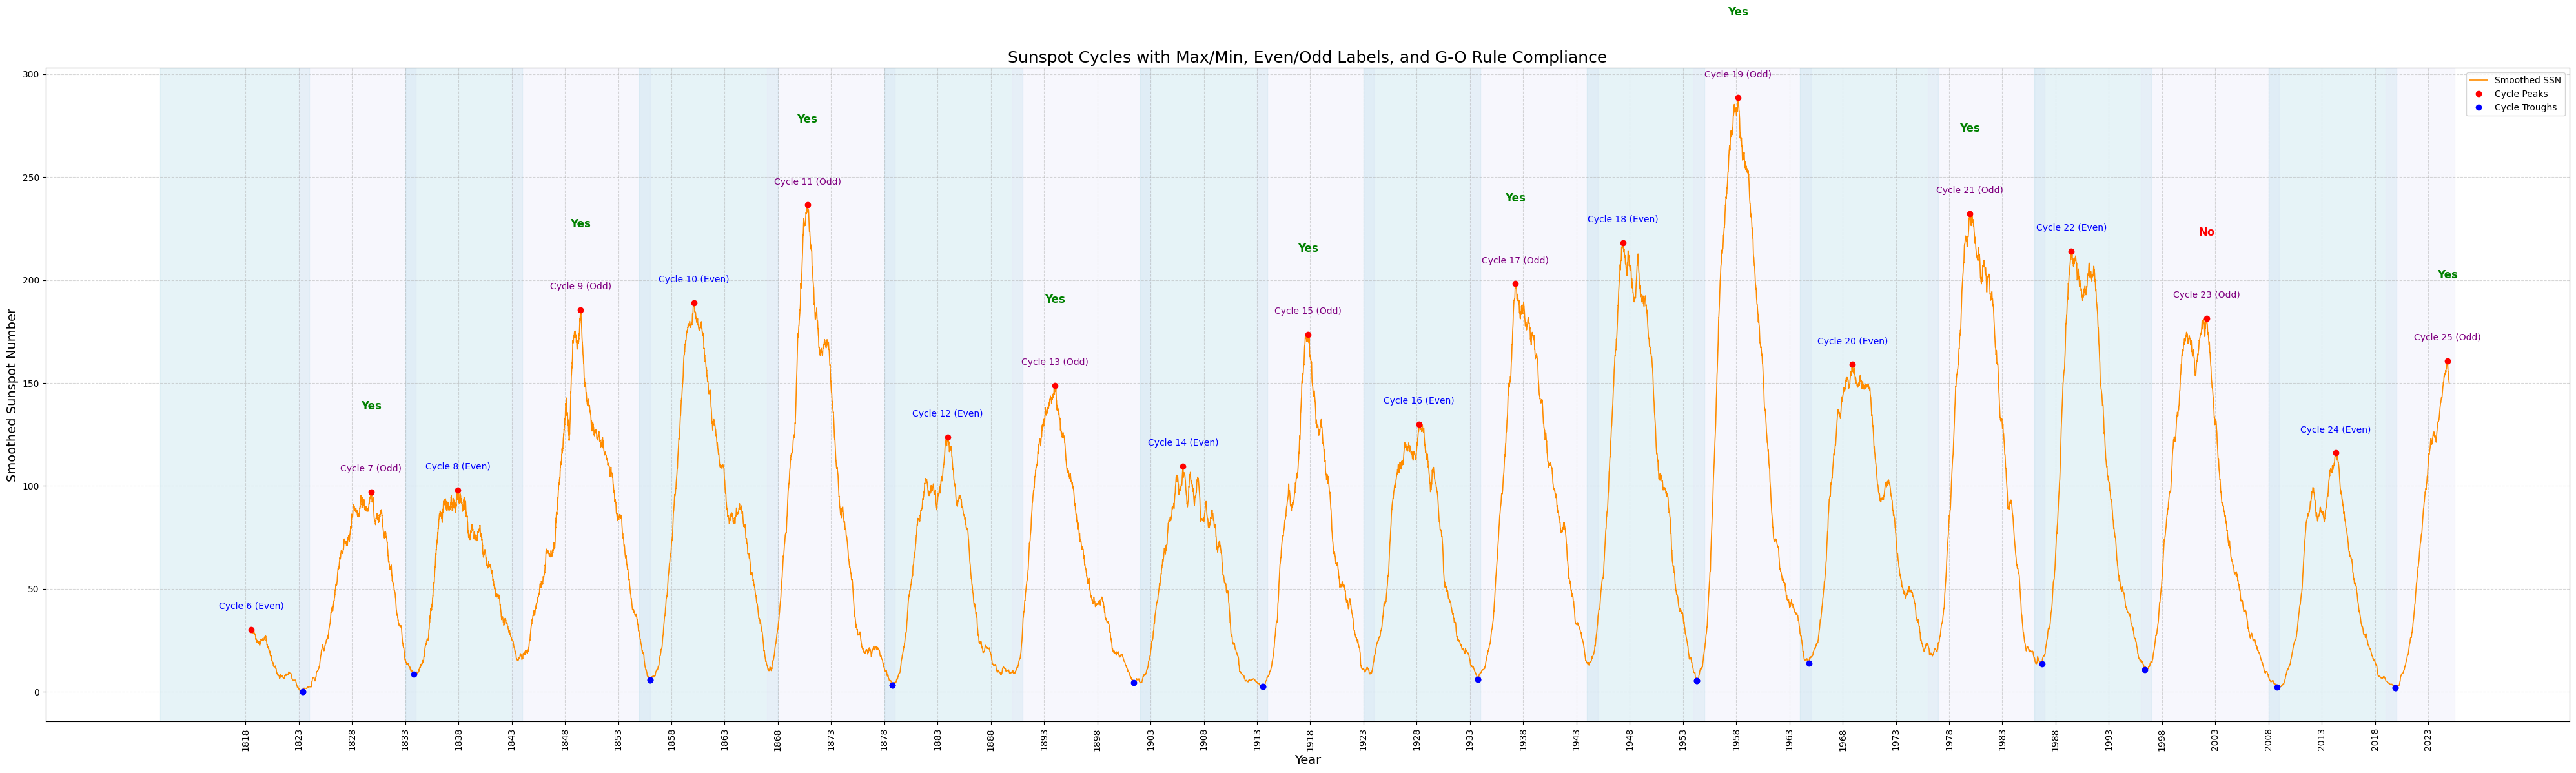

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Load data ===
df = pd.read_csv("SN_data.csv", parse_dates=["Date"])
df["SSN_smoothed"] = df["Sunspot_Number"].rolling(window=390, center=True).mean()

# === Define solar cycle boundaries ===
solar_cycles = [
    (5, "1798-01-01", "1810-12-31"),
    (6, "1810-01-01", "1823-12-31"),
    (7, "1823-01-01", "1833-12-31"),
    (8, "1833-01-01", "1843-12-31"),
    (9, "1843-01-01", "1855-12-31"),
    (10,"1855-01-01", "1867-12-31"),
    (11,"1867-01-01", "1878-12-31"),
    (12,"1878-01-01", "1890-12-31"),
    (13,"1890-01-01", "1902-12-31"),
    (14,"1902-01-01", "1913-12-31"),
    (15,"1913-01-01", "1923-12-31"),
    (16,"1923-01-01", "1933-12-31"),
    (17,"1933-01-01", "1944-12-31"),
    (18,"1944-01-01", "1954-12-31"),
    (19,"1954-01-01", "1964-12-31"),
    (20,"1964-01-01", "1976-12-31"),
    (21,"1976-01-01", "1986-12-31"),
    (22,"1986-01-01", "1996-12-31"),
    (23,"1996-01-01", "2008-12-31"),
    (24,"2008-01-01", "2019-12-31"),
    (25,"2019-01-01", df["Date"].max().strftime("%Y-%m-%d")),  # ongoing
]

# === Find peak & trough values per cycle ===
cycle_extrema = []
for num, start, end in solar_cycles:
    mask = (df["Date"] >= start) & (df["Date"] <= end)
    subset = df.loc[mask]
    if not subset.empty:
        # Peak (max)
        peak_idx = subset["SSN_smoothed"].idxmax()
        peak_date = df.loc[peak_idx, "Date"]
        peak_val = df.loc[peak_idx, "SSN_smoothed"]
        # Trough (min)
        trough_idx = subset["SSN_smoothed"].idxmin()
        trough_date = df.loc[trough_idx, "Date"]
        trough_val = df.loc[trough_idx, "SSN_smoothed"]
        cycle_extrema.append([num, start, end, peak_date, peak_val, trough_date, trough_val])

df_extrema = pd.DataFrame(cycle_extrema, 
                          columns=["Cycle", "Start", "End", "Peak_Date", "Peak_SSN", "Trough_Date", "Trough_SSN"])

# === Compute ΔMax (Odd vs Even) ===
results = []
for i in range(1, len(df_extrema)):
    prev_cycle = df_extrema.iloc[i-1]
    curr_cycle = df_extrema.iloc[i]
    if curr_cycle["Cycle"] % 2 == 1:  # Odd cycle
        delta_max = curr_cycle["Peak_SSN"] - prev_cycle["Peak_SSN"]
        compliance = "Yes" if delta_max > 0 else "No"
        results.append([prev_cycle["Cycle"], prev_cycle["Peak_SSN"],
                        curr_cycle["Cycle"], curr_cycle["Peak_SSN"],
                        delta_max, compliance])

df_results = pd.DataFrame(results, columns=["Even_Cycle", "Even_Peak",
                                            "Odd_Cycle", "Odd_Peak",
                                            "Delta_Max", "GO_Compliance"])

print("\nG-O Rule Compliance Table (Real Solar Cycles):")
print(df_results)

# === Plot ===
plt.figure(figsize=(40, 12))
plt.plot(df["Date"], df["SSN_smoothed"], color="darkorange", linewidth=1.2, label="Smoothed SSN")

# Shade each cycle (alternating colors)
for idx, row in df_extrema.iterrows():
    color = "lightblue" if row["Cycle"] % 2 == 0 else "lavender"
    plt.axvspan(pd.to_datetime(row["Start"]), pd.to_datetime(row["End"]), color=color, alpha=0.3)

# Mark peaks (red) and troughs (blue)
plt.plot(df_extrema["Peak_Date"], df_extrema["Peak_SSN"], "ro", label="Cycle Peaks")
plt.plot(df_extrema["Trough_Date"], df_extrema["Trough_SSN"], "bo", label="Cycle Troughs")

# Annotate cycle numbers + Even/Odd tag at peaks
for _, row in df_extrema.iterrows():
    cycle_type = "Odd" if row["Cycle"] % 2 == 1 else "Even"
    plt.text(row["Peak_Date"], row["Peak_SSN"]+10,
             f"Cycle {row['Cycle']} ({cycle_type})",
             fontsize=10, ha='center',
             color="purple" if cycle_type == "Odd" else "blue")

# Annotate G-O compliance (Yes/No) above odd cycle peaks
for _, row in df_results.iterrows():
    odd_cycle = row["Odd_Cycle"]
    odd_date = df_extrema.loc[df_extrema["Cycle"] == odd_cycle, "Peak_Date"].values[0]
    odd_value = df_extrema.loc[df_extrema["Cycle"] == odd_cycle, "Peak_SSN"].values[0]
    plt.text(pd.to_datetime(odd_date), odd_value+40,
             f"{row['GO_Compliance']}",
             fontsize=12, ha='center',
             color="green" if row["GO_Compliance"] == "Yes" else "red",
             fontweight="bold")

plt.title("Sunspot Cycles with Max/Min, Even/Odd Labels, and G-O Rule Compliance", fontsize=18)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Smoothed Sunspot Number", fontsize=14)

# X-axis formatting
years = pd.date_range(start=df["Date"].min(), end=df["Date"].max(), freq='YS')
plt.xticks(years[::5], [str(y.year) for y in years[::5]], rotation=90)

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


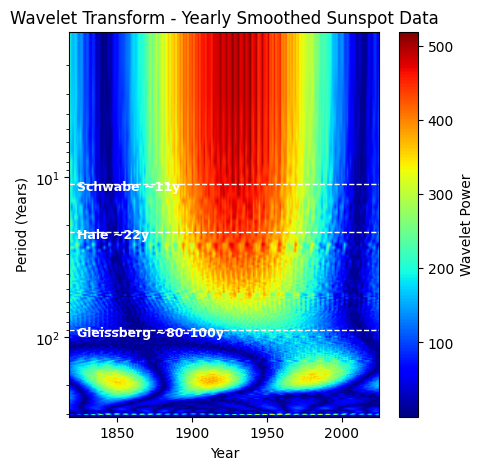

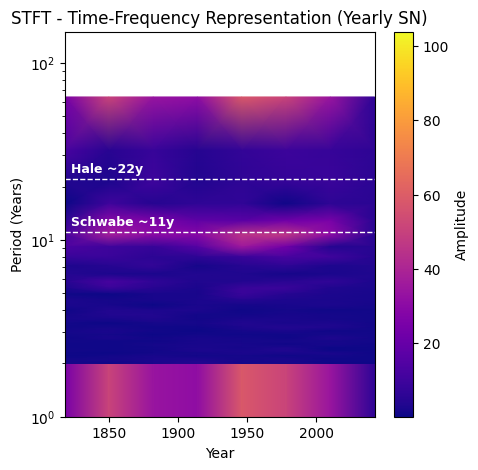

In [8]:
# Wavelet and STFT with periodicity highlights
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import stft

# === Load correct data file ===
df = pd.read_csv("SN_data_yearly_with_cycles.csv")
time = df["Year"].values
signal = df["Smoothed_Yearly_Sunspot_Number"].values

# === Wavelet Transform ===
dt = 1  # yearly resolution
scales = np.arange(1, 256)  # extended to capture Gleissberg
coefficients, frequencies = pywt.cwt(signal, scales, 'morl', sampling_period=dt)

# Convert frequencies → periods
periods = 1 / frequencies

# Plot Wavelet Power Spectrum
plt.figure(figsize=(5,5))
plt.imshow(np.abs(coefficients), extent=[time[0], time[-1], periods.min(), periods.max()],
           cmap='jet', aspect='auto', interpolation='bilinear')
plt.colorbar(label='Wavelet Power')
plt.title("Wavelet Transform - Yearly Smoothed Sunspot Data")
plt.xlabel("Year")
plt.ylabel("Period (Years)")
plt.yscale('log')
plt.gca().invert_yaxis()

# Highlight main cycles
for p, label in [(11, "Schwabe ~11y"), (22, "Hale ~22y"), (90, "Gleissberg ~80–100y")]:
    plt.axhline(y=p, color='white', linestyle='--', linewidth=1)
    plt.text(time[0]+5, p*1.1, label, color='white', fontsize=9, fontweight='bold')

plt.show()

# === Short-Time Fourier Transform (STFT) ===
f, t, Zxx = stft(signal, fs=1.0, nperseg=64, noverlap=32)

# Convert frequency → period
periods_stft = np.divide(1, f, out=np.zeros_like(f), where=f!=0)

plt.figure(figsize=(5,5))
plt.pcolormesh(t + time[0], periods_stft, np.abs(Zxx), shading='gouraud', cmap='plasma')
plt.title("STFT - Time-Frequency Representation (Yearly SN)")
plt.xlabel("Year")
plt.ylabel("Period (Years)")
plt.colorbar(label="Amplitude")
plt.ylim(1, 150)  # show cycles up to 150 years
plt.yscale("log")

# Highlight main cycles
for p, label in [(11, "Schwabe ~11y"), (22, "Hale ~22y"), (90, "Gleissberg ~80–100y")]:
    plt.axhline(y=p, color='white', linestyle='--', linewidth=1)
    plt.text(time[0]+5, p*1.1, label, color='white', fontsize=9, fontweight='bold')

plt.show()


=== Hemispheric Lead/Lag (global) ===
North leads South: ~1.7 months (~0.14 years), r=0.87

=== Top |AI| spikes (date -> AI) ===
2019-06-09 +0.907
2019-06-10 +0.907
2019-06-11 +0.907
2019-06-14 +0.906
2019-06-12 +0.906
2019-06-13 +0.906
2019-06-15 +0.905
2019-06-23 +0.904
2019-06-18 +0.904
2019-06-17 +0.904

Saved: Hemispheric_AI_timeseries.csv


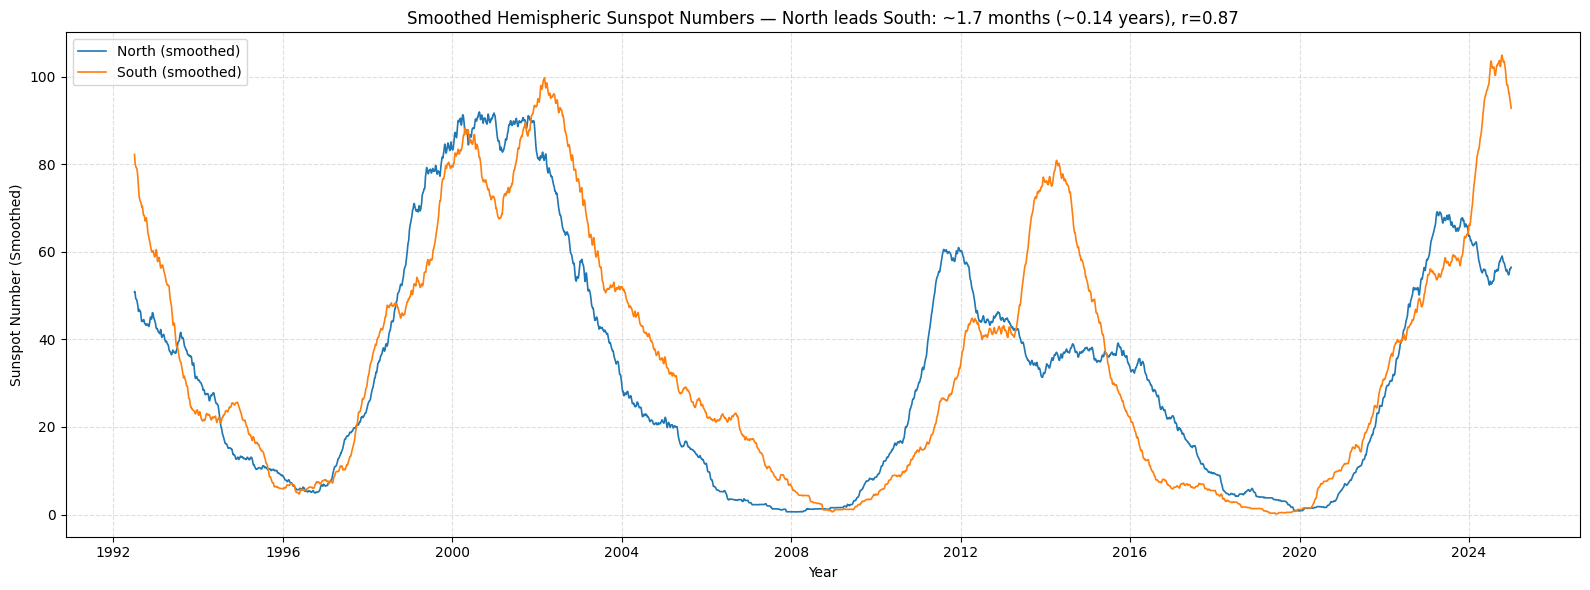

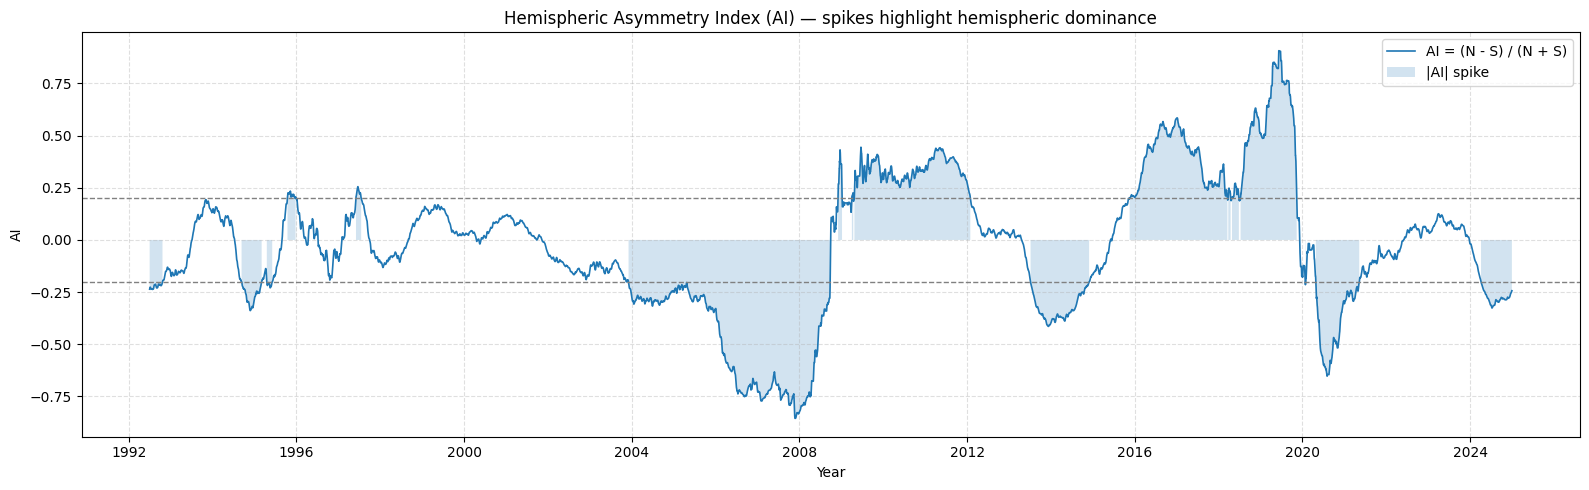

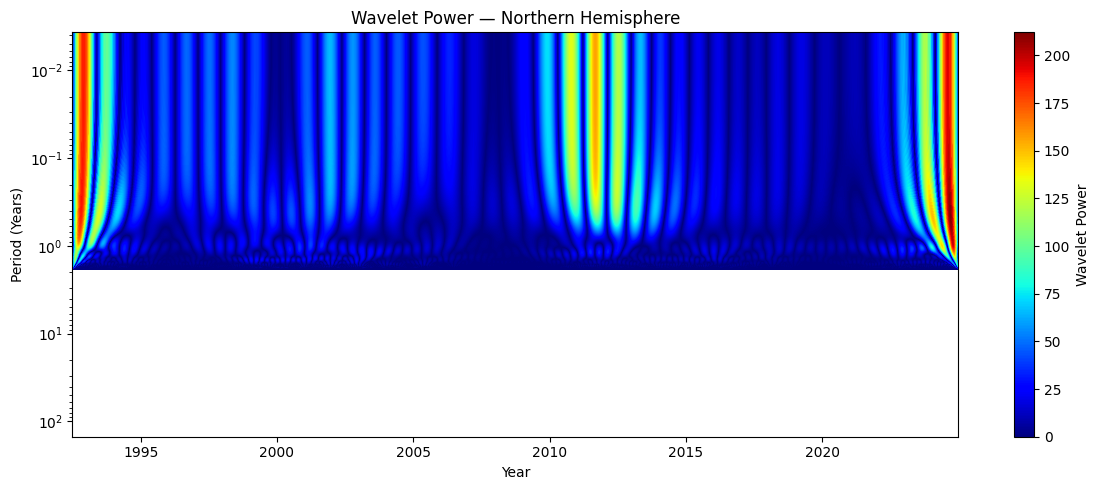

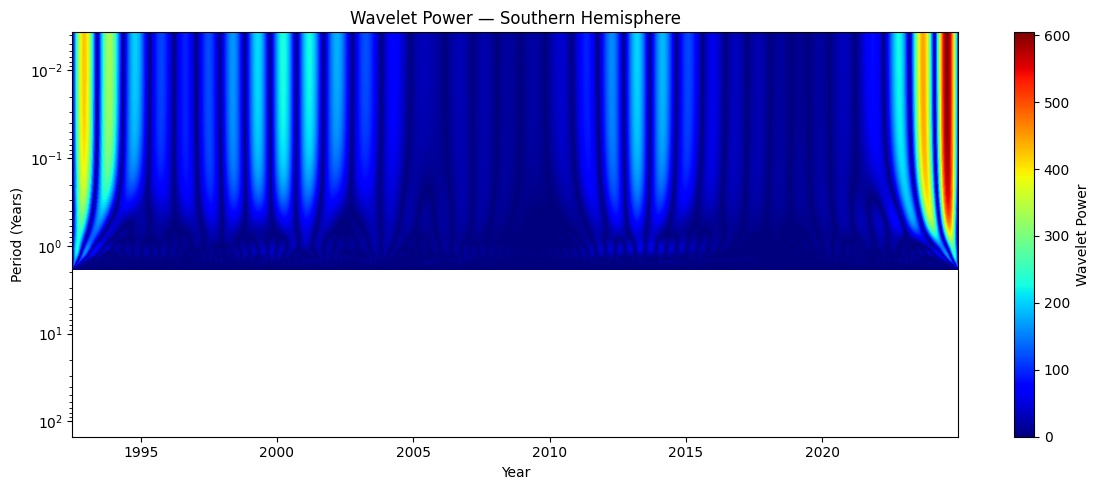

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

# =========================
# Load hemispheric data
# =========================
df = pd.read_csv("Hemispheric_SN_data_smoothed.csv", parse_dates=["Date"])

# Columns expected:
# ['Date','Year','Month','Day','Decimal_Year','SN_Total','SN_North','SN_South',
#  'STD_Total','STD_North','STD_South','Obs_Total','Obs_North','Obs_South','Definitive',
#  'SN_Total_Smoothed','SN_North_Smoothed','SN_South_Smoothed']

# Use the already smoothed hemispheric series
t = pd.to_datetime(df["Date"])
north = df["SN_North_Smoothed"].astype(float).to_numpy()
south = df["SN_South_Smoothed"].astype(float).to_numpy()
years = df["Decimal_Year"].astype(float).to_numpy()

# Some datasets start with NaNs at edges of smoothing; drop them safely
mask = np.isfinite(north) & np.isfinite(south) & np.isfinite(years)
t = t[mask]
years = years[mask]
north = north[mask]
south = south[mask]

# =========================
# Hemispheric Asymmetry Index (AI)
# =========================
den = north + south
ai = np.zeros_like(north, dtype=float)
safe = den != 0
ai[safe] = (north[safe] - south[safe]) / den[safe]
ai[~safe] = np.nan

# Optional: simple smoothing of AI (comment out if not wanted)
# ai_sm = pd.Series(ai, index=t).rolling(13, center=True, min_periods=1).mean().to_numpy()
ai_sm = ai

# =========================
# Lead/Lag estimation (global)
# find lag in months that maximizes cross-correlation (±48 months)
# =========================
# infer sampling step in years from Decimal_Year; convert to months for reporting
dt_years = np.median(np.diff(years))
dt_months = dt_years * 12.0

def best_lag(x, y, max_lag_steps=48):
    # normalize
    xz = (x - np.nanmean(x)) / np.nanstd(x)
    yz = (y - np.nanmean(y)) / np.nanstd(y)
    lags = np.arange(-max_lag_steps, max_lag_steps+1)
    best_r = -np.inf
    best_k = 0
    for k in lags:
        if k < 0:
            r = np.nanmean(xz[-k:] * yz[:k or None])
        elif k > 0:
            r = np.nanmean(xz[:-k] * yz[k:])
        else:
            r = np.nanmean(xz * yz)
        if r > best_r:
            best_r, best_k = r, k
    return best_k, best_r

lag_steps, lag_corr = best_lag(north, south, max_lag_steps=48)
lag_months = lag_steps * dt_months
lag_years = lag_months / 12.0
lead_text = ("North leads South" if lag_steps > 0 else
             "South leads North" if lag_steps < 0 else
             "No lead/lag")
lead_summary = f"{lead_text}: ~{abs(lag_months):.1f} months (~{abs(lag_years):.2f} years), r={lag_corr:.2f}"

print("=== Hemispheric Lead/Lag (global) ===")
print(lead_summary)

# =========================
# Flag AI spikes
# =========================
AI_THRESHOLD = 0.20  # tweak if you want stricter/looser spikes
spike_mask = np.abs(ai_sm) >= AI_THRESHOLD

# Build a small summary of spike peaks
ai_series = pd.Series(ai_sm, index=t)
peaks = ai_series[spike_mask]
top_spikes = peaks.reindex(peaks.abs().sort_values(ascending=False).index).head(10)
print("\n=== Top |AI| spikes (date -> AI) ===")
for idx, val in top_spikes.items():
    print(idx.date(), f"{val:+.3f}")

# Save AI + flags
out = pd.DataFrame({
    "Date": t,
    "Decimal_Year": years,
    "SN_North_Smoothed": north,
    "SN_South_Smoothed": south,
    "AI": ai_sm,
    "AI_spike_abs>={:.2f}".format(AI_THRESHOLD): spike_mask
})
out.to_csv("Hemispheric_AI_timeseries.csv", index=False)
print("\nSaved: Hemispheric_AI_timeseries.csv")

# =========================
# PLOTS
# =========================

# ---- Plot 1: North vs South with lead/lag info ----
plt.figure(figsize=(16, 6))
plt.plot(t, north, label="North (smoothed)", linewidth=1.2)
plt.plot(t, south, label="South (smoothed)", linewidth=1.2)
plt.title(f"Smoothed Hemispheric Sunspot Numbers — {lead_summary}")
plt.xlabel("Year")
plt.ylabel("Sunspot Number (Smoothed)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: Asymmetry Index over time, highlight spikes ----
plt.figure(figsize=(16, 5))
plt.plot(t, ai_sm, linewidth=1.2, label="AI = (N - S) / (N + S)")
plt.axhline(+AI_THRESHOLD, color="gray", linestyle="--", linewidth=1)
plt.axhline(-AI_THRESHOLD, color="gray", linestyle="--", linewidth=1)
plt.fill_between(t, ai_sm, 0, where=spike_mask, alpha=0.2, label="|AI| spike")
plt.title("Hemispheric Asymmetry Index (AI) — spikes highlight hemispheric dominance")
plt.xlabel("Year")
plt.ylabel("AI")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# Wavelet per hemisphere
# =========================
def wavelet_panel(time_years, series, title):
    # Remove NaNs for wavelet
    ok = np.isfinite(series) & np.isfinite(time_years)
    s = series[ok]
    ty = time_years[ok]
    # sampling period in years
    dt = np.median(np.diff(ty))
    # choose scales to cover ~1–150 years
    scales = np.arange(1, 512)
    coeffs, freqs = pywt.cwt(s, scales, 'morl', sampling_period=dt)
    periods = 1 / freqs

    plt.figure(figsize=(12, 5))
    plt.imshow(np.abs(coeffs),
               extent=[ty[0], ty[-1], periods.min(), periods.max()],
               cmap='jet', aspect='auto', interpolation='bilinear')
    plt.colorbar(label='Wavelet Power')
    plt.yscale('log')
    plt.gca().invert_yaxis()
    for p, label in [(11, "Schwabe ~11y"), (22, "Hale ~22y"), (90, "Gleissberg ~80–100y")]:
        plt.axhline(y=p, color='white', linestyle='--', linewidth=1)
        plt.text(ty[0]+(ty[-1]-ty[0])*0.02, p*1.10, label, color='white', fontsize=9, fontweight='bold')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Period (Years)")
    plt.tight_layout()
    plt.show()

wavelet_panel(years, north, "Wavelet Power — Northern Hemisphere")
wavelet_panel(years, south, "Wavelet Power — Southern Hemisphere")



=== G-O Rule Table ===
   Even_Cycle  Odd_Cycle  Delta_Max  Delta_Total  Violation
0         6.0        7.0  64.437899   533.080208      False
1         8.0        9.0 -19.034188   199.415451       True
2        10.0       11.0  49.822419     8.569182      False
3        12.0       13.0  35.917808   132.365911      False
4        14.0       15.0  68.136986   123.003496      False
5        16.0       17.0  60.919762   315.504948      False
6        18.0       19.0  54.569863   254.836582      False
7        20.0       21.0  70.046613   188.911715      False
8        22.0       23.0 -37.194131   -17.188846       True
9        24.0       25.0  41.403428   -15.847069      False


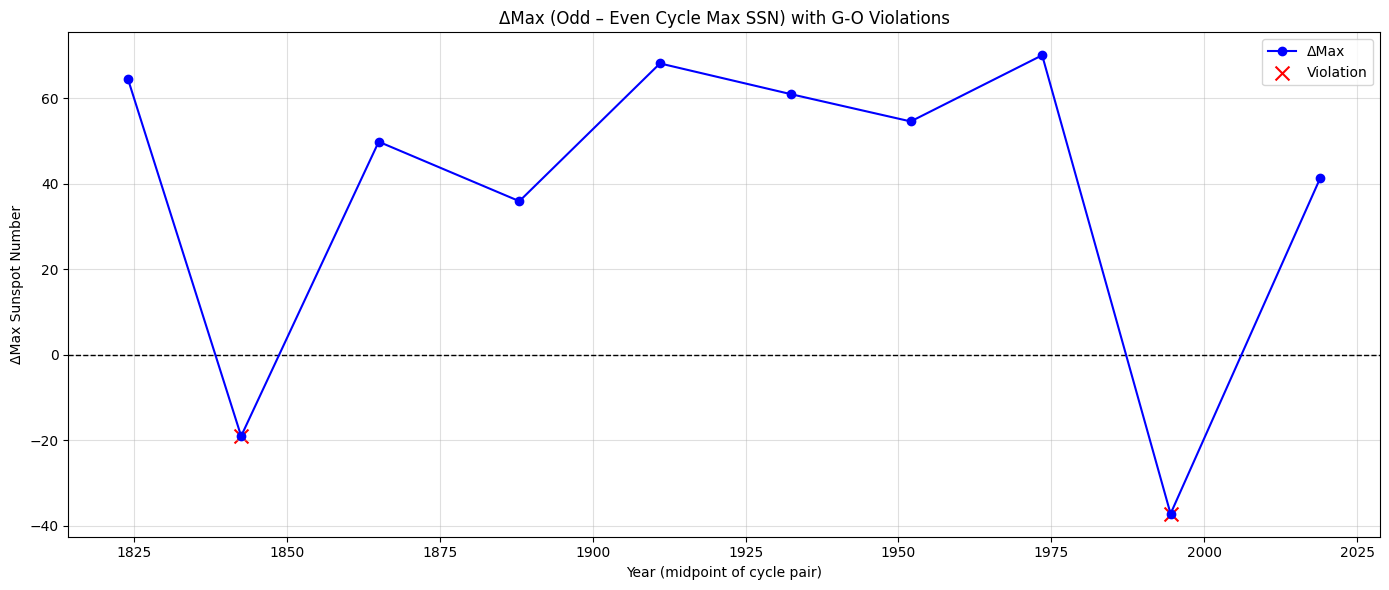

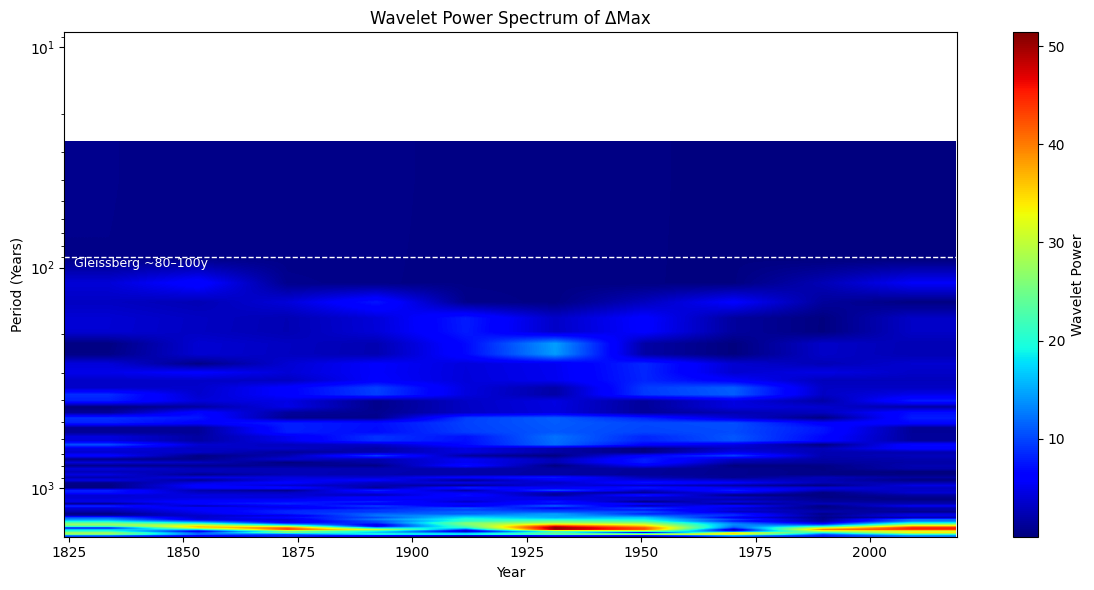

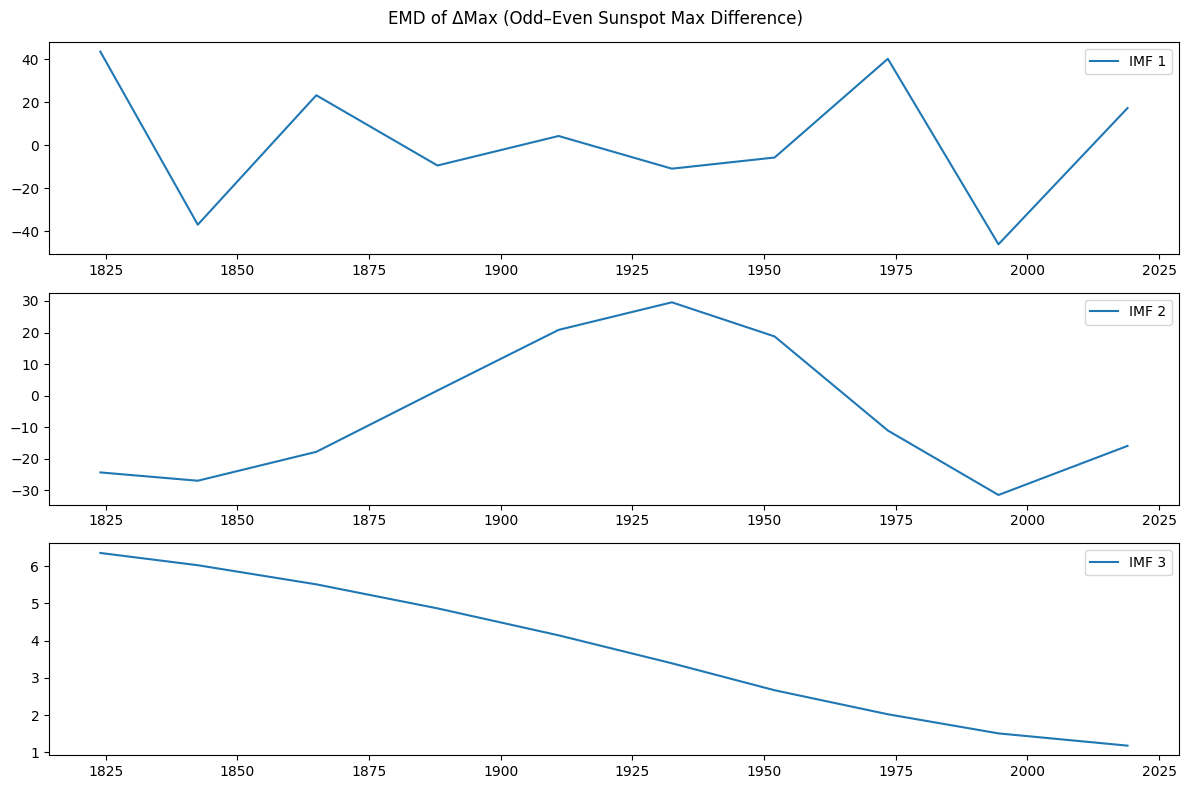

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PyEMD import EMD

# ======================
# Load data
# ======================
df = pd.read_csv("GO_rule_analysis.csv")

# Columns: ['Even_Cycle','Odd_Cycle','Even_Max','Odd_Max',
#           'Delta_Max','Even_Total','Odd_Total','Delta_Total','Midpoint_Year']

# Add violation flag
df["Violation"] = df["Delta_Max"] < 0

print("\n=== G-O Rule Table ===")
print(df[["Even_Cycle","Odd_Cycle","Delta_Max","Delta_Total","Violation"]])

# ======================
# Plot ΔMax vs time
# ======================
plt.figure(figsize=(14,6))
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.plot(df["Midpoint_Year"], df["Delta_Max"], "o-", color="blue", label="ΔMax")

# highlight violations
viol_mask = df["Violation"]
plt.scatter(df.loc[viol_mask,"Midpoint_Year"],
            df.loc[viol_mask,"Delta_Max"],
            color="red", s=100, marker="x", label="Violation")

plt.title("ΔMax (Odd – Even Cycle Max SSN) with G-O Violations")
plt.xlabel("Year (midpoint of cycle pair)")
plt.ylabel("ΔMax Sunspot Number")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ======================
# Wavelet analysis of ΔMax
# ======================
signal = df["Delta_Max"].values
time = df["Midpoint_Year"].values

# Normalize (optional)
signal = signal - np.nanmean(signal)

dt = np.median(np.diff(time))
scales = np.arange(1, 64)
coeffs, freqs = pywt.cwt(signal, scales, 'morl', sampling_period=dt)
periods = 1/freqs

plt.figure(figsize=(12,6))
plt.imshow(np.abs(coeffs),
           extent=[time[0], time[-1], periods.min(), periods.max()],
           cmap="jet", aspect="auto", interpolation="bilinear")
plt.yscale("log")
plt.gca().invert_yaxis()
plt.colorbar(label="Wavelet Power")
for p,label in [(11,"Schwabe ~11y"),(22,"Hale ~22y"),(90,"Gleissberg ~80–100y")]:
    plt.axhline(p,color="white",linestyle="--",linewidth=1)
    plt.text(time[0]+2,p*1.1,label,color="white",fontsize=9)
plt.title("Wavelet Power Spectrum of ΔMax")
plt.xlabel("Year")
plt.ylabel("Period (Years)")
plt.tight_layout()
plt.show()

# ======================
# EMD analysis of ΔMax
# ======================
emd = EMD()
imfs = emd(signal)

plt.figure(figsize=(12,8))
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs),1,i+1)
    plt.plot(time, imf, label=f"IMF {i+1}")
    plt.legend(loc="upper right")
plt.suptitle("EMD of ΔMax (Odd–Even Sunspot Max Difference)")
plt.tight_layout()
plt.show()



Polar Field Summary at Minima:
   Cycle  Min_Year   Polar_Avg  Polar_North  Polar_South
0     20      1976   96.741379    91.603448  -101.982759
1     21      1986 -124.963636  -113.427273   136.454545
2     22      1996   93.509091    97.136364   -89.781818
3     23      2008  -53.577982   -53.302752    53.834862
4     24      2019   61.888889    65.518519   -58.324074
5     25      2025  -18.468085   -22.468085    14.319149

Polar Field vs G-O Rule (Lagged):
   Cycle  Next_Cycle  Polar_Avg  Polar_North  Polar_South  Delta_Max  \
0   20.0        21.0  96.741379    91.603448  -101.982759  70.046613   
1   22.0        23.0  93.509091    97.136364   -89.781818 -37.194131   
2   24.0        25.0  61.888889    65.518519   -58.324074  41.403428   

   Violation  
0      False  
1       True  
2      False  


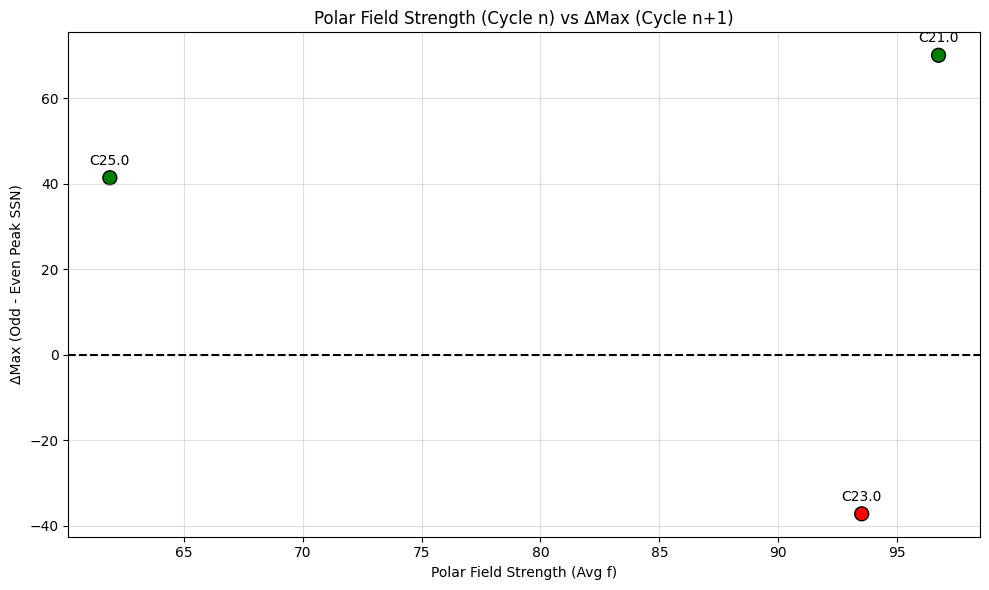


Correlation Results:
Polar Avg vs ΔMax: -0.178
Polar North vs ΔMax: -0.414
Polar South vs ΔMax: -0.012
✅ Report saved: Polar_vs_GO_Rule.xlsx + Polar_vs_DeltaMax.jpeg


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================
# Load datasets
# ======================
go_df = pd.read_csv("GO_rule_analysis.csv")
polar_df = pd.read_csv("WSO_polar_field_clean.csv", parse_dates=["Date"])

# Polar field data starts ~1976
polar_df["Year"] = polar_df["Date"].dt.year

# ======================
# Step 1: Aggregate polar fields at solar minima (~cycle boundaries)
# ======================
cycle_minima = {
    20: 1976,
    21: 1986,
    22: 1996,
    23: 2008,
    24: 2019,
    25: 2025  # approximate ongoing
}

polar_strength = []
for cycle, year in cycle_minima.items():
    subset = polar_df[(polar_df["Year"] >= year-1) & (polar_df["Year"] <= year+1)]
    if not subset.empty:
        avg_strength = subset["Avgf"].mean()
        north_strength = subset["Nf"].mean()
        south_strength = subset["Sf"].mean()
        polar_strength.append([cycle, year, avg_strength, north_strength, south_strength])

polar_df_summary = pd.DataFrame(
    polar_strength,
    columns=["Cycle","Min_Year","Polar_Avg","Polar_North","Polar_South"]
)
print("\nPolar Field Summary at Minima:")
print(polar_df_summary)

# ======================
# Step 2: Merge with GO Rule data (lagged: polar of cycle n vs ∆Max of n+1)
# ======================
merged = []
for i, row in polar_df_summary.iterrows():
    cycle = row["Cycle"]
    next_cycle = cycle + 1
    go_match = go_df[go_df["Odd_Cycle"] == next_cycle]
    if not go_match.empty:
        delta_max = go_match["Delta_Max"].values[0]
        violation = go_match["Delta_Max"].values[0] < 0
        merged.append([
            cycle, next_cycle, row["Polar_Avg"], row["Polar_North"], row["Polar_South"],
            delta_max, violation
        ])

df_corr = pd.DataFrame(
    merged,
    columns=["Cycle","Next_Cycle","Polar_Avg","Polar_North","Polar_South",
             "Delta_Max","Violation"]
)

print("\nPolar Field vs G-O Rule (Lagged):")
print(df_corr)

# ======================
# Step 3: Scatter plot (Polar vs ∆Max)
# ======================
plt.figure(figsize=(10,6))
colors = df_corr["Violation"].map({True:"red",False:"green"})
plt.scatter(df_corr["Polar_Avg"], df_corr["Delta_Max"], c=colors, s=100, edgecolor="k")

for _, row in df_corr.iterrows():
    plt.text(row["Polar_Avg"], row["Delta_Max"]+3, f"C{row['Next_Cycle']}", ha="center")

plt.axhline(0, color="black", linestyle="--")
plt.title("Polar Field Strength (Cycle n) vs ΔMax (Cycle n+1)")
plt.xlabel("Polar Field Strength (Avg f)")
plt.ylabel("ΔMax (Odd - Even Peak SSN)")
plt.grid(True, alpha=0.4)
plt.tight_layout()

# Save scatter plot as JPEG
plt.savefig("Polar_vs_DeltaMax.jpeg", dpi=300)
plt.show()

# ======================
# Step 4: Correlation
# ======================
corr_avg = np.corrcoef(df_corr["Polar_Avg"], df_corr["Delta_Max"])[0,1]
corr_north = np.corrcoef(df_corr["Polar_North"], df_corr["Delta_Max"])[0,1]
corr_south = np.corrcoef(df_corr["Polar_South"], df_corr["Delta_Max"])[0,1]

print("\nCorrelation Results:")
print(f"Polar Avg vs ΔMax: {corr_avg:.3f}")
print(f"Polar North vs ΔMax: {corr_north:.3f}")
print(f"Polar South vs ΔMax: {corr_south:.3f}")

# ======================
# Step 5: Export tables to Excel
# ======================
with pd.ExcelWriter("Polar_vs_GO_Rule.xlsx") as writer:
    polar_df_summary.to_excel(writer, sheet_name="Polar_Minima", index=False)
    df_corr.to_excel(writer, sheet_name="Polar_vs_DeltaMax", index=False)
    pd.DataFrame({
        "Correlation": ["Polar Avg vs ΔMax", "Polar North vs ΔMax", "Polar South vs ΔMax"],
        "Value": [corr_avg, corr_north, corr_south]
    }).to_excel(writer, sheet_name="Correlations", index=False)

print("✅ Report saved: Polar_vs_GO_Rule.xlsx + Polar_vs_DeltaMax.jpeg")


In [2]:
import pandas as pd
import numpy as np

# -------------------------------
# 1️⃣ Load CSV files
# -------------------------------
cycle_go = pd.read_csv('Cyclewise_G-O_Analysis_With_Asymmetry.csv')
go_analysis = pd.read_csv('GO_rule_analysis.csv')
polar_field = pd.read_csv('WSO_polar_field_clean.csv')
cycle_strength = pd.read_csv('solar_cycle_strength_analysis.csv')
sunspot_peaks = pd.read_csv('sunspot_cycle_peaks.csv')
hemispheric_strength = pd.read_csv('Yearly_Hemispheric_Strength_by_Cycle.csv')

# -------------------------------
# 2️⃣ Explicit G-O Rule Violations per Hemisphere
# -------------------------------
# Using Cyclewise_G-O_Analysis_With_Asymmetry.csv columns: North_G_O_Pass, South_G_O_Pass
# Convert True/False or pass/fail to Yes/No for report
def yes_no(val):
    if isinstance(val, str):
        return 'Yes' if val.lower() in ['true','pass','yes'] else 'No'
    return 'Yes' if val else 'No'

cycle_go['North_G_O_Violation'] = cycle_go['North_G_O_Pass'].apply(lambda x: 'No' if yes_no(x)=='Yes' else 'Yes')
cycle_go['South_G_O_Violation'] = cycle_go['South_G_O_Pass'].apply(lambda x: 'No' if yes_no(x)=='Yes' else 'Yes')

# -------------------------------
# 3️⃣ Merge G-O Analysis with Polar Field
# -------------------------------
# Use 'Midpoint_Year' in go_analysis to get closest polar field value
polar_field['Year'] = pd.to_datetime(polar_field['Date']).dt.year

def get_polar_field(year, df):
    # If exact year exists, take Avgf
    if year in df['Year'].values:
        return df.loc[df['Year']==year, 'Avgf'].values[0]
    # Else take nearest year
    nearest = df.iloc[(df['Year']-year).abs().argsort()[:1]]
    return nearest['Avgf'].values[0]

go_analysis['Polar_Field_Odd_Start'] = go_analysis['Midpoint_Year'].apply(lambda x: get_polar_field(int(x), polar_field))

# Flag violations
go_analysis['Violation'] = go_analysis['Delta_Max'].apply(lambda x: 'Yes' if x>0 else 'No')

# -------------------------------
# 4️⃣ Summary Tables
# -------------------------------
# Table 1: Cycle Peaks & Durations
cycle_summary = cycle_strength.copy()
cycle_summary = cycle_summary.rename(columns={
    'Solar_Cycle_Number':'Cycle',
    'Max_Sunspot_Number':'Max_SN',
    'Year_of_Max':'Year_of_Max_SN',
    'Cycle_Integrated_SSN':'Integrated_SN'
})
cycle_summary = cycle_summary[['Cycle','Start_Year','End_Year','Duration','Max_SN','Year_of_Max_SN','Integrated_SN','Rise/Fall_Ratio']]

# Table 2: G-O Rule Summary
go_summary = go_analysis[['Odd_Cycle','Even_Cycle','Odd_Max','Even_Max','Delta_Max','Odd_Total','Even_Total','Delta_Total','Polar_Field_Odd_Start','Violation']]
go_summary = go_summary.rename(columns={
    'Odd_Cycle':'Odd_Cycle','Even_Cycle':'Even_Cycle',
    'Odd_Max':'Odd_Max_SN','Even_Max':'Even_Max_SN',
    'Delta_Max':'Delta_Max_SN','Odd_Total':'Odd_Integrated_SN','Even_Total':'Even_Integrated_SN',
    'Delta_Total':'Delta_Integrated_SN','Polar_Field_Odd_Start':'Polar_Field_Odd_Start','Violation':'G_O_Violation'
})

# Table 3: Hemispheric Asymmetry
hemispheric_summary = cycle_go[['Cycle','Peak_Asymmetry_Index','Mean_Asymmetry_Index','North_G_O_Violation','South_G_O_Violation']]
hemispheric_summary = hemispheric_summary.rename(columns={
    'North_G_O_Violation':'North_G_O_Violation',
    'South_G_O_Violation':'South_G_O_Violation'
})

# -------------------------------
# 5️⃣ Wavelet Commentary Template
# -------------------------------
wavelet_commentary = """
Wavelet Power Spectrum Observations:
- Dominant periodicity: ~11-year Schwabe cycle visible across most cycles.
- Amplitude modulation: Suppressed power during weak cycles (e.g., Dalton, Maunder-like minima).
- Hemispheric differences: Northern hemisphere often shows slightly stronger 11-year peak than South in recent cycles.
- G-O rule relation: Violations often coincide with lower power or amplitude modulation in wavelet spectra.
- Longer periodicities (~22-year Hale cycle) visible in cross-wavelet or large-scale trends.
"""

# -------------------------------
# 6️⃣ Export to Excel
# -------------------------------
with pd.ExcelWriter('GO_Rule_Full_Report.xlsx') as writer:
    cycle_summary.to_excel(writer, sheet_name='Cycle_Peaks_Duration', index=False)
    go_summary.to_excel(writer, sheet_name='G_O_Rule_Summary', index=False)
    hemispheric_summary.to_excel(writer, sheet_name='Hemispheric_Asymmetry', index=False)
    # Add wavelet commentary as a sheet
    pd.DataFrame({'Wavelet_Commentary':[wavelet_commentary]}).to_excel(writer, sheet_name='Wavelet_Commentary', index=False)

print("✅ Full report tables exported to 'GO_Rule_Full_Report.xlsx'")


✅ Full report tables exported to 'GO_Rule_Full_Report.xlsx'



G-O Rule Compliance Table (Real Solar Cycles):
   Even_Cycle   Even_Peak  Odd_Cycle    Odd_Peak  Delta_Max GO_Compliance
0           6   30.217949          7   97.102564  66.884615           Yes
1           8   98.043590          9  185.500000  87.456410           Yes
2          10  189.035897         11  236.474359  47.438462           Yes
3          12  123.748718         13  148.869231  25.120513           Yes
4          14  109.684615         15  173.669231  63.984615           Yes
5          16  130.053846         17  198.210256  68.156410           Yes
6          18  218.176923         19  288.510256  70.333333           Yes
7          20  158.961538         21  232.179487  73.217949           Yes
8          22  213.912821         23  181.517949 -32.394872            No
9          24  116.007692         25  160.784615  44.776923           Yes


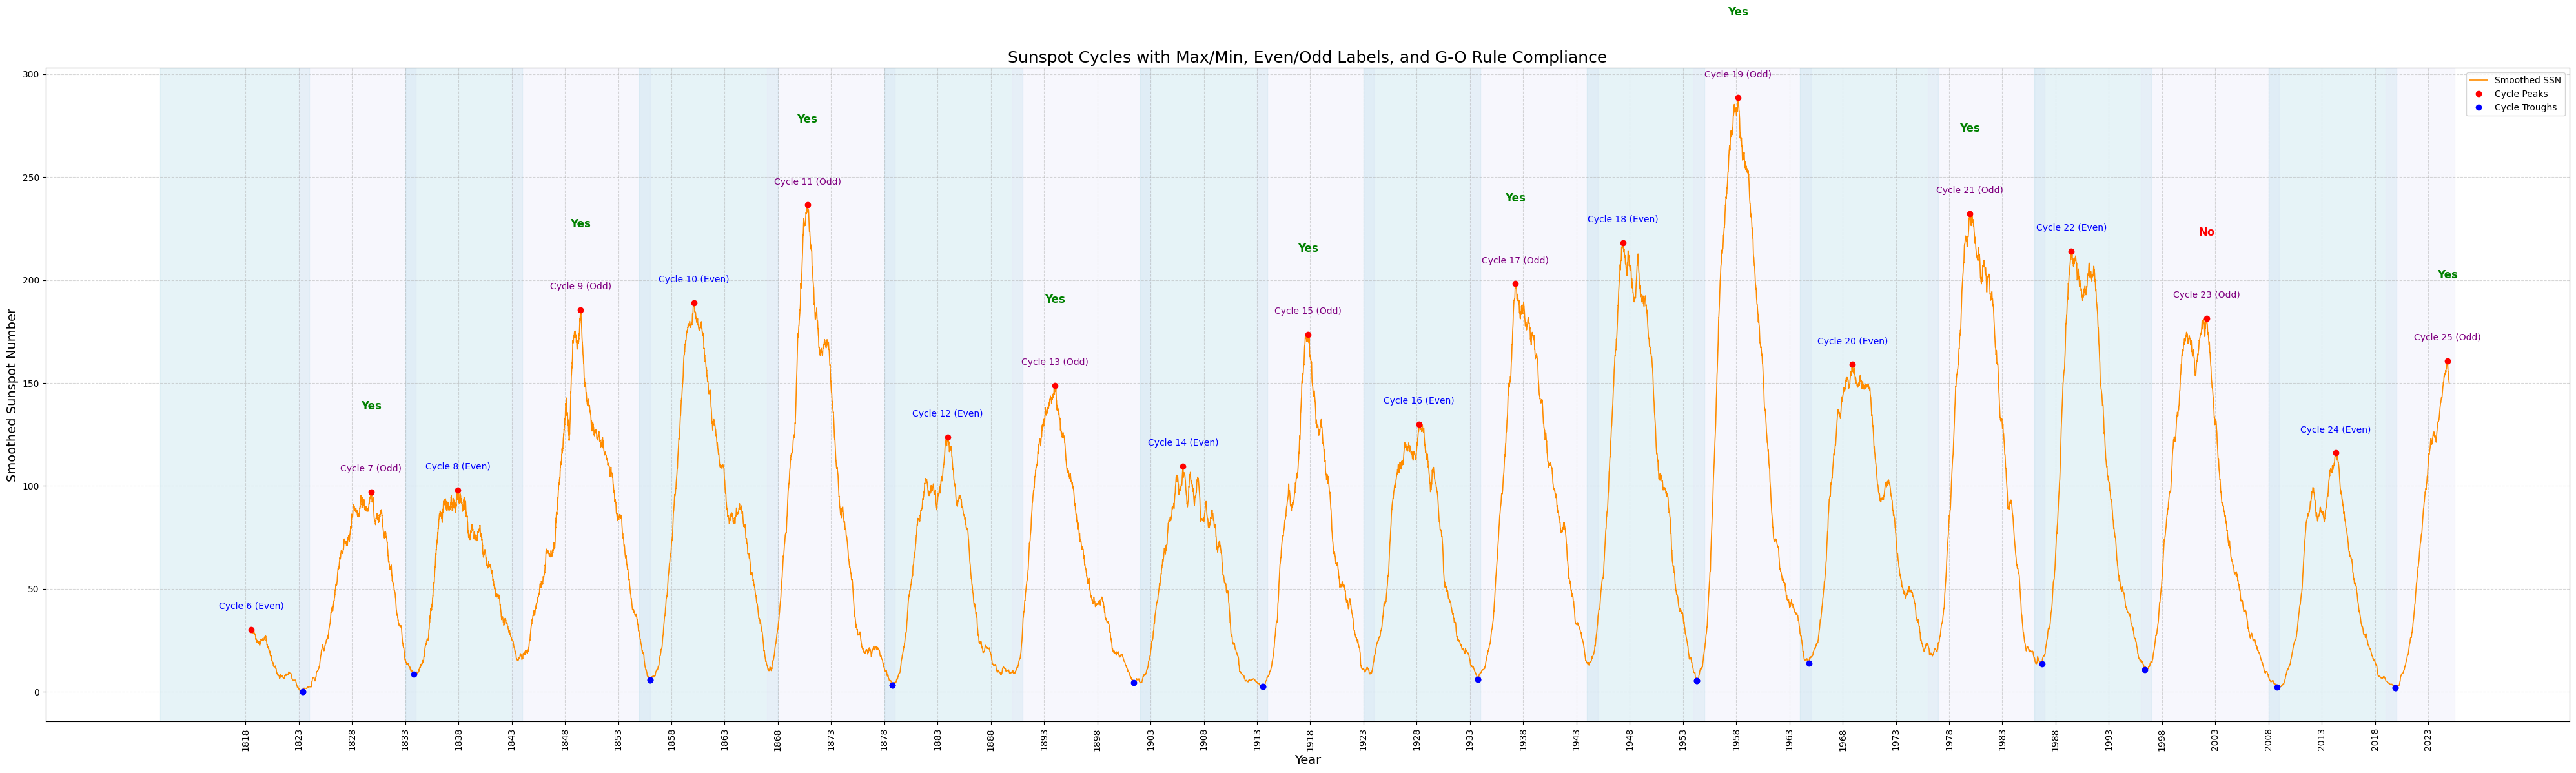

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Load data ===
df = pd.read_csv("SN_data.csv", parse_dates=["Date"])
df["SSN_smoothed"] = df["Sunspot_Number"].rolling(window=390, center=True).mean()

# === Define solar cycle boundaries ===
solar_cycles = [
    (5, "1798-01-01", "1810-12-31"),
    (6, "1810-01-01", "1823-12-31"),
    (7, "1823-01-01", "1833-12-31"),
    (8, "1833-01-01", "1843-12-31"),
    (9, "1843-01-01", "1855-12-31"),
    (10,"1855-01-01", "1867-12-31"),
    (11,"1867-01-01", "1878-12-31"),
    (12,"1878-01-01", "1890-12-31"),
    (13,"1890-01-01", "1902-12-31"),
    (14,"1902-01-01", "1913-12-31"),
    (15,"1913-01-01", "1923-12-31"),
    (16,"1923-01-01", "1933-12-31"),
    (17,"1933-01-01", "1944-12-31"),
    (18,"1944-01-01", "1954-12-31"),
    (19,"1954-01-01", "1964-12-31"),
    (20,"1964-01-01", "1976-12-31"),
    (21,"1976-01-01", "1986-12-31"),
    (22,"1986-01-01", "1996-12-31"),
    (23,"1996-01-01", "2008-12-31"),
    (24,"2008-01-01", "2019-12-31"),
    (25,"2019-01-01", df["Date"].max().strftime("%Y-%m-%d")),  # ongoing
]

# === Find peak & trough values per cycle ===
cycle_extrema = []
for num, start, end in solar_cycles:
    mask = (df["Date"] >= start) & (df["Date"] <= end)
    subset = df.loc[mask]
    if not subset.empty:
        # Peak (max)
        peak_idx = subset["SSN_smoothed"].idxmax()
        peak_date = df.loc[peak_idx, "Date"]
        peak_val = df.loc[peak_idx, "SSN_smoothed"]
        # Trough (min)
        trough_idx = subset["SSN_smoothed"].idxmin()
        trough_date = df.loc[trough_idx, "Date"]
        trough_val = df.loc[trough_idx, "SSN_smoothed"]
        cycle_extrema.append([num, start, end, peak_date, peak_val, trough_date, trough_val])

df_extrema = pd.DataFrame(cycle_extrema, 
                          columns=["Cycle", "Start", "End", "Peak_Date", "Peak_SSN", "Trough_Date", "Trough_SSN"])

# === Compute ΔMax (Odd vs Even) ===
results = []
for i in range(1, len(df_extrema)):
    prev_cycle = df_extrema.iloc[i-1]
    curr_cycle = df_extrema.iloc[i]
    if curr_cycle["Cycle"] % 2 == 1:  # Odd cycle
        delta_max = curr_cycle["Peak_SSN"] - prev_cycle["Peak_SSN"]
        compliance = "Yes" if delta_max > 0 else "No"
        results.append([prev_cycle["Cycle"], prev_cycle["Peak_SSN"],
                        curr_cycle["Cycle"], curr_cycle["Peak_SSN"],
                        delta_max, compliance])

df_results = pd.DataFrame(results, columns=["Even_Cycle", "Even_Peak",
                                            "Odd_Cycle", "Odd_Peak",
                                            "Delta_Max", "GO_Compliance"])

print("\nG-O Rule Compliance Table (Real Solar Cycles):")
print(df_results)

# === Plot ===
plt.figure(figsize=(40, 12))
plt.plot(df["Date"], df["SSN_smoothed"], color="darkorange", linewidth=1.2, label="Smoothed SSN")

# Shade each cycle (alternating colors)
for idx, row in df_extrema.iterrows():
    color = "lightblue" if row["Cycle"] % 2 == 0 else "lavender"
    plt.axvspan(pd.to_datetime(row["Start"]), pd.to_datetime(row["End"]), color=color, alpha=0.3)

# Mark peaks (red) and troughs (blue)
plt.plot(df_extrema["Peak_Date"], df_extrema["Peak_SSN"], "ro", label="Cycle Peaks")
plt.plot(df_extrema["Trough_Date"], df_extrema["Trough_SSN"], "bo", label="Cycle Troughs")

# Annotate cycle numbers + Even/Odd tag at peaks
for _, row in df_extrema.iterrows():
    cycle_type = "Odd" if row["Cycle"] % 2 == 1 else "Even"
    plt.text(row["Peak_Date"], row["Peak_SSN"]+10,
             f"Cycle {row['Cycle']} ({cycle_type})",
             fontsize=10, ha='center',
             color="purple" if cycle_type == "Odd" else "blue")

# Annotate G-O compliance (Yes/No) above odd cycle peaks
for _, row in df_results.iterrows():
    odd_cycle = row["Odd_Cycle"]
    odd_date = df_extrema.loc[df_extrema["Cycle"] == odd_cycle, "Peak_Date"].values[0]
    odd_value = df_extrema.loc[df_extrema["Cycle"] == odd_cycle, "Peak_SSN"].values[0]
    plt.text(pd.to_datetime(odd_date), odd_value+40,
             f"{row['GO_Compliance']}",
             fontsize=12, ha='center',
             color="green" if row["GO_Compliance"] == "Yes" else "red",
             fontweight="bold")

plt.title("Sunspot Cycles with Max/Min, Even/Odd Labels, and G-O Rule Compliance", fontsize=18)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Smoothed Sunspot Number", fontsize=14)

# X-axis formatting
years = pd.date_range(start=df["Date"].min(), end=df["Date"].max(), freq='YS')
plt.xticks(years[::5], [str(y.year) for y in years[::5]], rotation=90)

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# === Save figure as JPEG ===
plt.savefig("solar_cycles.jpeg", format="jpeg", dpi=300)

plt.show()


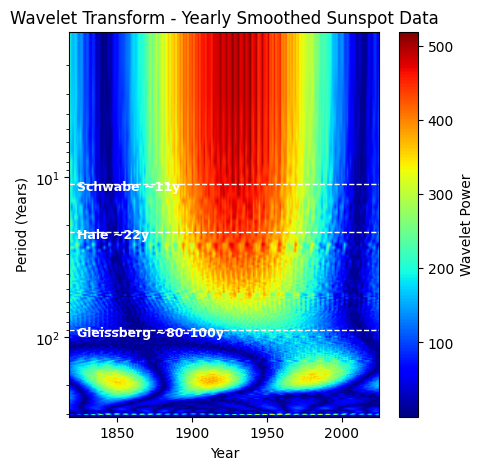

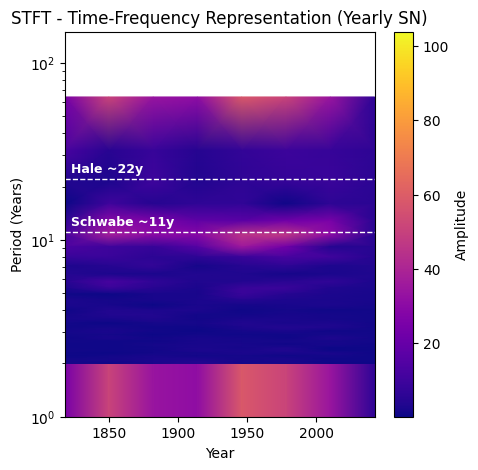

In [3]:
# Wavelet and STFT with periodicity highlights
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import stft

# === Load correct data file ===
df = pd.read_csv("SN_data_yearly_with_cycles.csv")
time = df["Year"].values
signal = df["Smoothed_Yearly_Sunspot_Number"].values

# === Wavelet Transform ===
dt = 1  # yearly resolution
scales = np.arange(1, 256)  # extended to capture Gleissberg
coefficients, frequencies = pywt.cwt(signal, scales, 'morl', sampling_period=dt)

# Convert frequencies → periods
periods = 1 / frequencies

# Plot Wavelet Power Spectrum
plt.figure(figsize=(5,5))
plt.imshow(np.abs(coefficients), extent=[time[0], time[-1], periods.min(), periods.max()],
           cmap='jet', aspect='auto', interpolation='bilinear')
plt.colorbar(label='Wavelet Power')
plt.title("Wavelet Transform - Yearly Smoothed Sunspot Data")
plt.xlabel("Year")
plt.ylabel("Period (Years)")
plt.yscale('log')
plt.gca().invert_yaxis()

# Highlight main cycles
for p, label in [(11, "Schwabe ~11y"), (22, "Hale ~22y"), (90, "Gleissberg ~80–100y")]:
    plt.axhline(y=p, color='white', linestyle='--', linewidth=1)
    plt.text(time[0]+5, p*1.1, label, color='white', fontsize=9, fontweight='bold')

# === Save Wavelet figure ===
plt.savefig("wavelet_transform.jpeg", format="jpeg", dpi=300)

plt.show()

# === Short-Time Fourier Transform (STFT) ===
f, t, Zxx = stft(signal, fs=1.0, nperseg=64, noverlap=32)

# Convert frequency → period
periods_stft = np.divide(1, f, out=np.zeros_like(f), where=f!=0)

plt.figure(figsize=(5,5))
plt.pcolormesh(t + time[0], periods_stft, np.abs(Zxx), shading='gouraud', cmap='plasma')
plt.title("STFT - Time-Frequency Representation (Yearly SN)")
plt.xlabel("Year")
plt.ylabel("Period (Years)")
plt.colorbar(label="Amplitude")
plt.ylim(1, 150)  # show cycles up to 150 years
plt.yscale("log")

# Highlight main cycles
for p, label in [(11, "Schwabe ~11y"), (22, "Hale ~22y"), (90, "Gleissberg ~80–100y")]:
    plt.axhline(y=p, color='white', linestyle='--', linewidth=1)
    plt.text(time[0]+5, p*1.1, label, color='white', fontsize=9, fontweight='bold')

# === Save STFT figure ===
plt.savefig("stft_transform.jpeg", format="jpeg", dpi=300)

plt.show()


=== Hemispheric Lead/Lag (global) ===
North leads South: ~1.7 months (~0.14 years), r=0.87

=== Top |AI| spikes (date -> AI) ===
2019-06-09 +0.907
2019-06-10 +0.907
2019-06-11 +0.907
2019-06-14 +0.906
2019-06-12 +0.906
2019-06-13 +0.906
2019-06-15 +0.905
2019-06-23 +0.904
2019-06-18 +0.904
2019-06-17 +0.904

Saved: Hemispheric_AI_timeseries.csv


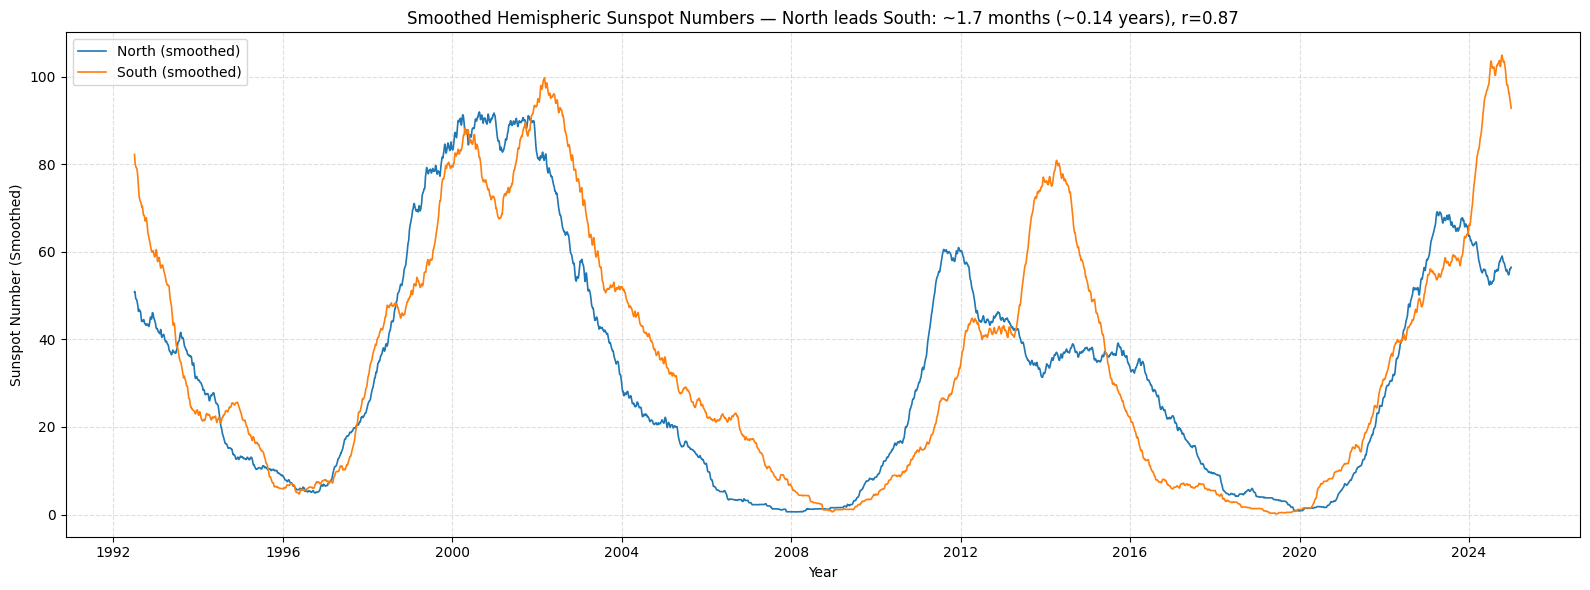

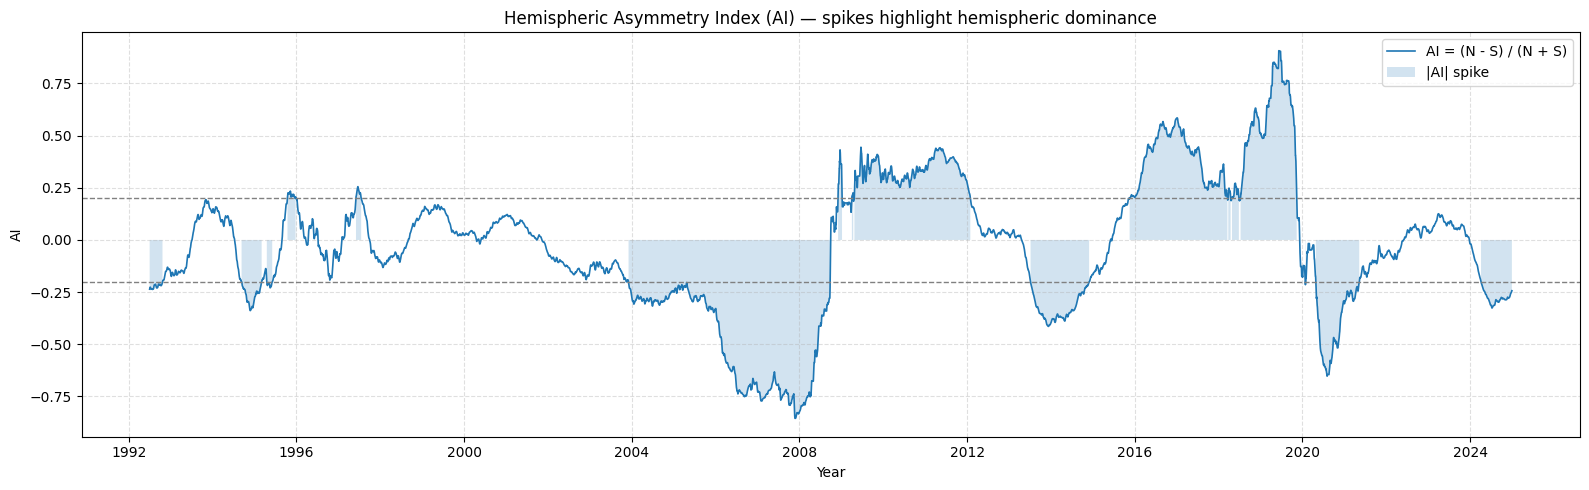

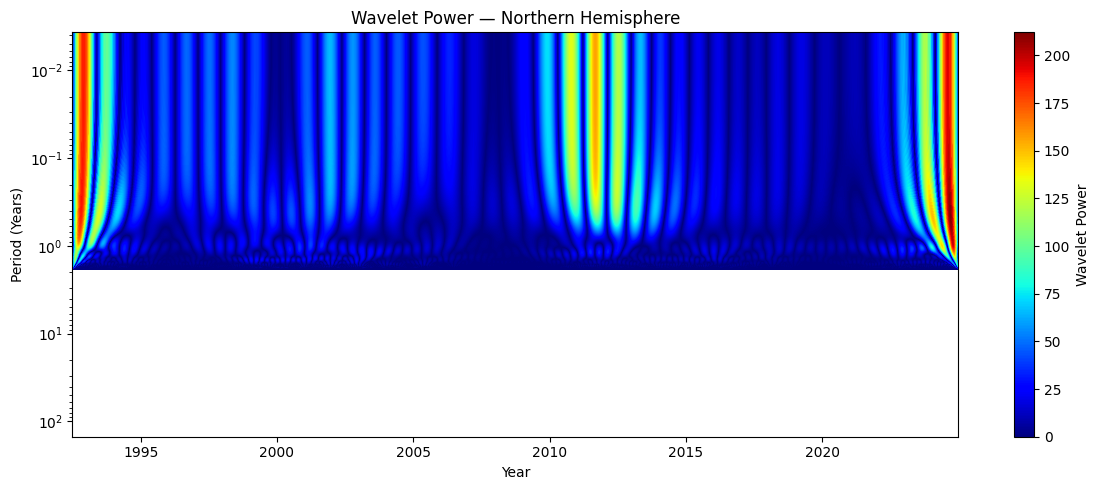

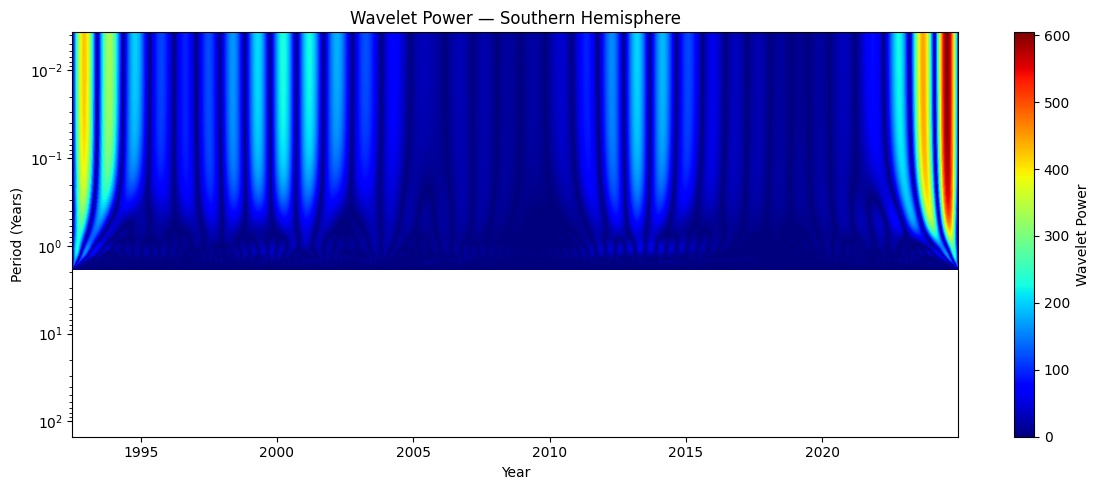

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

# =========================
# Load hemispheric data
# =========================
df = pd.read_csv("Hemispheric_SN_data_smoothed.csv", parse_dates=["Date"])

# Columns expected:
# ['Date','Year','Month','Day','Decimal_Year','SN_Total','SN_North','SN_South',
#  'STD_Total','STD_North','STD_South','Obs_Total','Obs_North','Obs_South','Definitive',
#  'SN_Total_Smoothed','SN_North_Smoothed','SN_South_Smoothed']

# Use the already smoothed hemispheric series
t = pd.to_datetime(df["Date"])
north = df["SN_North_Smoothed"].astype(float).to_numpy()
south = df["SN_South_Smoothed"].astype(float).to_numpy()
years = df["Decimal_Year"].astype(float).to_numpy()

# Some datasets start with NaNs at edges of smoothing; drop them safely
mask = np.isfinite(north) & np.isfinite(south) & np.isfinite(years)
t = t[mask]
years = years[mask]
north = north[mask]
south = south[mask]

# =========================
# Hemispheric Asymmetry Index (AI)
# =========================
den = north + south
ai = np.zeros_like(north, dtype=float)
safe = den != 0
ai[safe] = (north[safe] - south[safe]) / den[safe]
ai[~safe] = np.nan

# Optional: simple smoothing of AI (comment out if not wanted)
# ai_sm = pd.Series(ai, index=t).rolling(13, center=True, min_periods=1).mean().to_numpy()
ai_sm = ai

# =========================
# Lead/Lag estimation (global)
# find lag in months that maximizes cross-correlation (±48 months)
# =========================
# infer sampling step in years from Decimal_Year; convert to months for reporting
dt_years = np.median(np.diff(years))
dt_months = dt_years * 12.0

def best_lag(x, y, max_lag_steps=48):
    # normalize
    xz = (x - np.nanmean(x)) / np.nanstd(x)
    yz = (y - np.nanmean(y)) / np.nanstd(y)
    lags = np.arange(-max_lag_steps, max_lag_steps+1)
    best_r = -np.inf
    best_k = 0
    for k in lags:
        if k < 0:
            r = np.nanmean(xz[-k:] * yz[:k or None])
        elif k > 0:
            r = np.nanmean(xz[:-k] * yz[k:])
        else:
            r = np.nanmean(xz * yz)
        if r > best_r:
            best_r, best_k = r, k
    return best_k, best_r

lag_steps, lag_corr = best_lag(north, south, max_lag_steps=48)
lag_months = lag_steps * dt_months
lag_years = lag_months / 12.0
lead_text = ("North leads South" if lag_steps > 0 else
             "South leads North" if lag_steps < 0 else
             "No lead/lag")
lead_summary = f"{lead_text}: ~{abs(lag_months):.1f} months (~{abs(lag_years):.2f} years), r={lag_corr:.2f}"

print("=== Hemispheric Lead/Lag (global) ===")
print(lead_summary)

# =========================
# Flag AI spikes
# =========================
AI_THRESHOLD = 0.20  # tweak if you want stricter/looser spikes
spike_mask = np.abs(ai_sm) >= AI_THRESHOLD

# Build a small summary of spike peaks
ai_series = pd.Series(ai_sm, index=t)
peaks = ai_series[spike_mask]
top_spikes = peaks.reindex(peaks.abs().sort_values(ascending=False).index).head(10)
print("\n=== Top |AI| spikes (date -> AI) ===")
for idx, val in top_spikes.items():
    print(idx.date(), f"{val:+.3f}")

# Save AI + flags
out = pd.DataFrame({
    "Date": t,
    "Decimal_Year": years,
    "SN_North_Smoothed": north,
    "SN_South_Smoothed": south,
    "AI": ai_sm,
    "AI_spike_abs>={:.2f}".format(AI_THRESHOLD): spike_mask
})
out.to_csv("Hemispheric_AI_timeseries.csv", index=False)
print("\nSaved: Hemispheric_AI_timeseries.csv")

# =========================
# PLOTS
# =========================

# ---- Plot 1: North vs South with lead/lag info ----
plt.figure(figsize=(16, 6))
plt.plot(t, north, label="North (smoothed)", linewidth=1.2)
plt.plot(t, south, label="South (smoothed)", linewidth=1.2)
plt.title(f"Smoothed Hemispheric Sunspot Numbers — {lead_summary}")
plt.xlabel("Year")
plt.ylabel("Sunspot Number (Smoothed)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("plot1_north_vs_south.jpeg", format="jpeg", dpi=300)
plt.show()

# ---- Plot 2: Asymmetry Index over time, highlight spikes ----
plt.figure(figsize=(16, 5))
plt.plot(t, ai_sm, linewidth=1.2, label="AI = (N - S) / (N + S)")
plt.axhline(+AI_THRESHOLD, color="gray", linestyle="--", linewidth=1)
plt.axhline(-AI_THRESHOLD, color="gray", linestyle="--", linewidth=1)
plt.fill_between(t, ai_sm, 0, where=spike_mask, alpha=0.2, label="|AI| spike")
plt.title("Hemispheric Asymmetry Index (AI) — spikes highlight hemispheric dominance")
plt.xlabel("Year")
plt.ylabel("AI")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("plot2_AI_timeseries.jpeg", format="jpeg", dpi=300)
plt.show()

# =========================
# Wavelet per hemisphere
# =========================
def wavelet_panel(time_years, series, title, filename):
    # Remove NaNs for wavelet
    ok = np.isfinite(series) & np.isfinite(time_years)
    s = series[ok]
    ty = time_years[ok]
    # sampling period in years
    dt = np.median(np.diff(ty))
    # choose scales to cover ~1–150 years
    scales = np.arange(1, 512)
    coeffs, freqs = pywt.cwt(s, scales, 'morl', sampling_period=dt)
    periods = 1 / freqs

    plt.figure(figsize=(12, 5))
    plt.imshow(np.abs(coeffs),
               extent=[ty[0], ty[-1], periods.min(), periods.max()],
               cmap='jet', aspect='auto', interpolation='bilinear')
    plt.colorbar(label='Wavelet Power')
    plt.yscale('log')
    plt.gca().invert_yaxis()
    for p, label in [(11, "Schwabe ~11y"), (22, "Hale ~22y"), (90, "Gleissberg ~80–100y")]:
        plt.axhline(y=p, color='white', linestyle='--', linewidth=1)
        plt.text(ty[0]+(ty[-1]-ty[0])*0.02, p*1.10, label, color='white', fontsize=9, fontweight='bold')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Period (Years)")
    plt.tight_layout()
    plt.savefig(filename, format="jpeg", dpi=300)
    plt.show()

wavelet_panel(years, north, "Wavelet Power — Northern Hemisphere", "plot3_wavelet_north.jpeg")
wavelet_panel(years, south, "Wavelet Power — Southern Hemisphere", "plot4_wavelet_south.jpeg")



=== G-O Rule Table ===
   Even_Cycle  Odd_Cycle  Delta_Max  Delta_Total  Violation
0         6.0        7.0  64.437899   533.080208      False
1         8.0        9.0 -19.034188   199.415451       True
2        10.0       11.0  49.822419     8.569182      False
3        12.0       13.0  35.917808   132.365911      False
4        14.0       15.0  68.136986   123.003496      False
5        16.0       17.0  60.919762   315.504948      False
6        18.0       19.0  54.569863   254.836582      False
7        20.0       21.0  70.046613   188.911715      False
8        22.0       23.0 -37.194131   -17.188846       True
9        24.0       25.0  41.403428   -15.847069      False


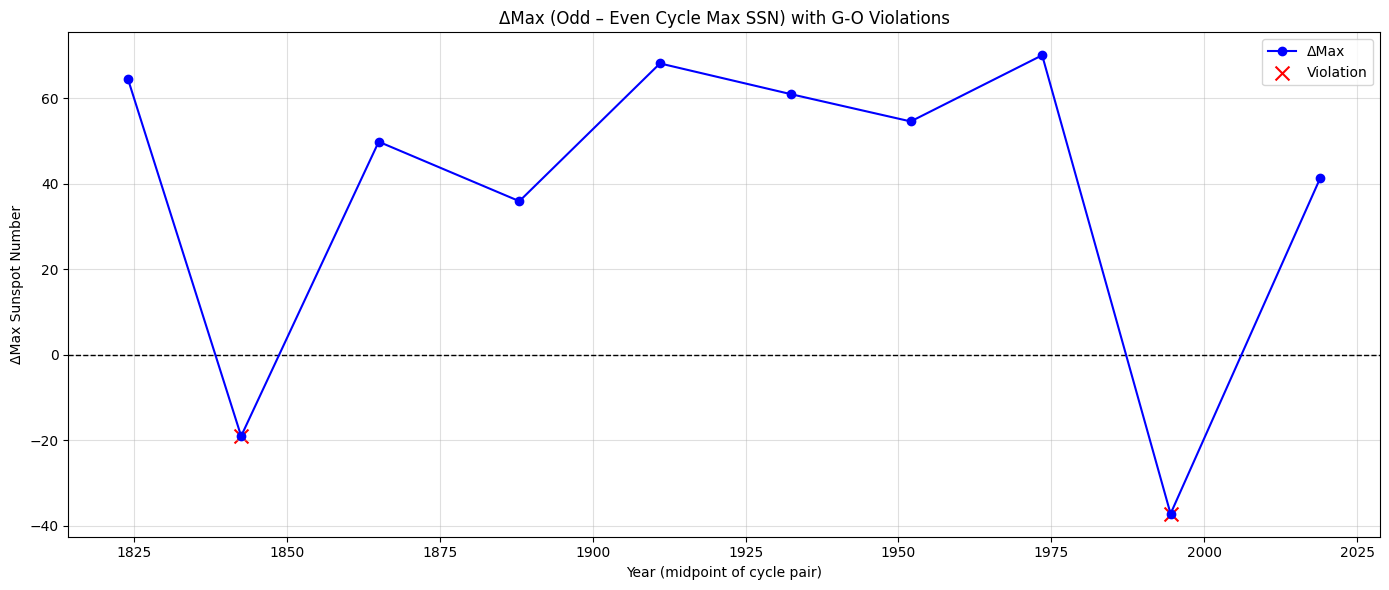

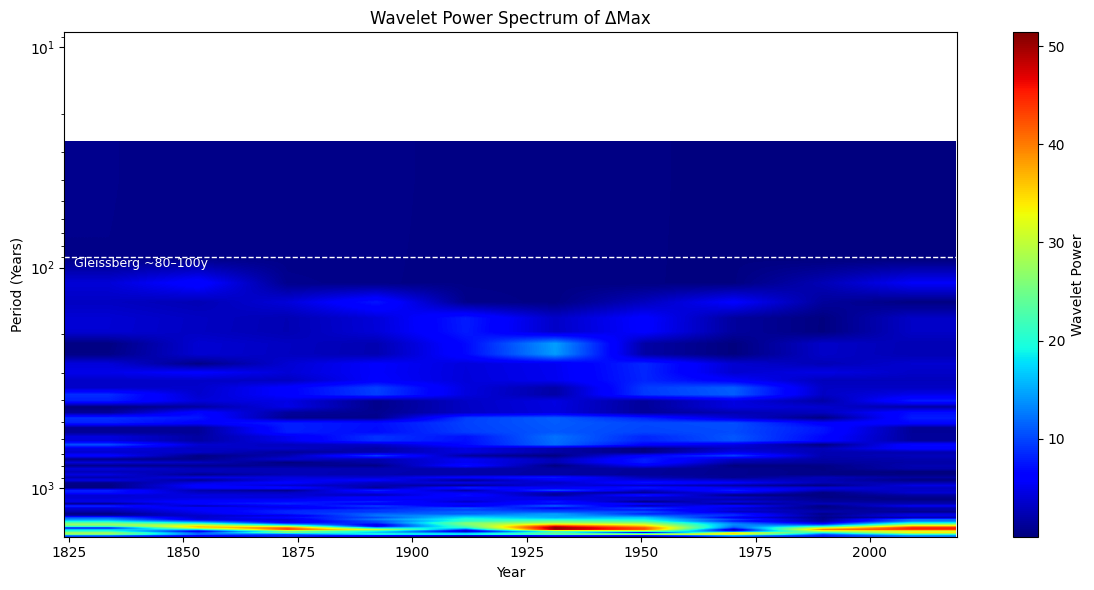

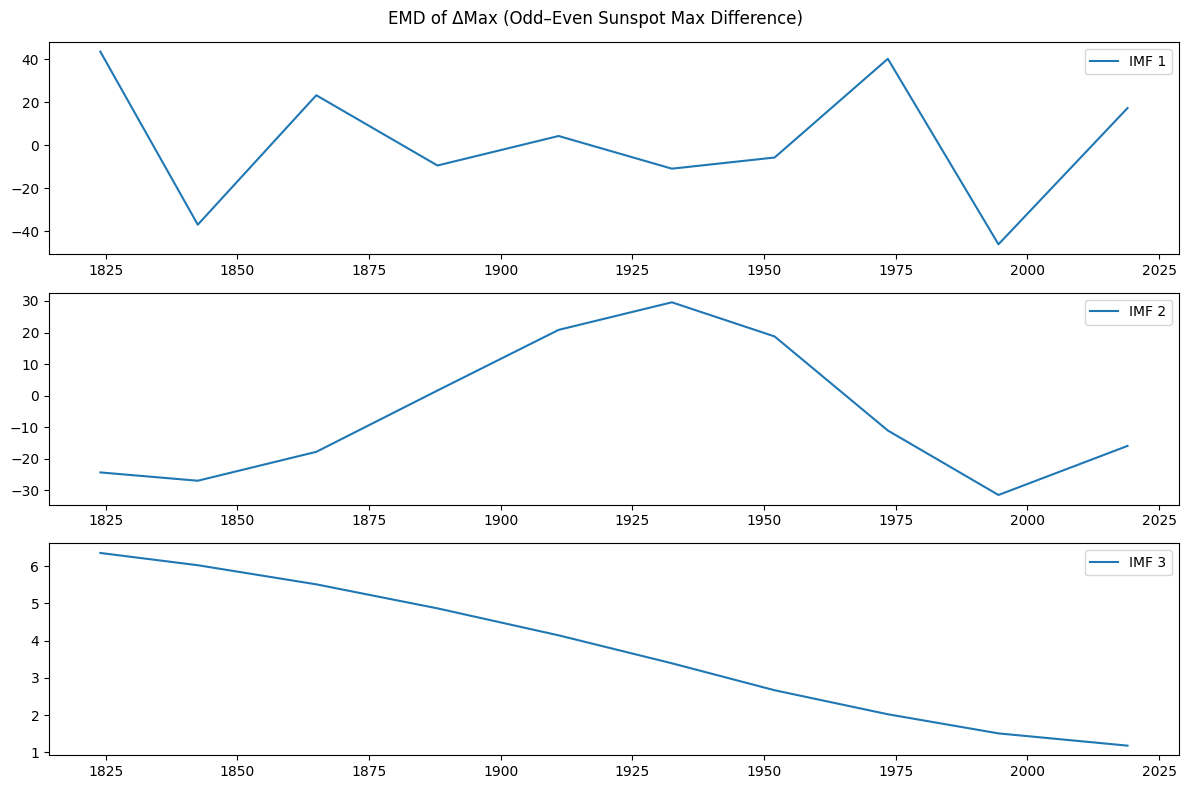

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PyEMD import EMD

# ======================
# Load data
# ======================
df = pd.read_csv("GO_rule_analysis.csv")

# Columns: ['Even_Cycle','Odd_Cycle','Even_Max','Odd_Max',
#           'Delta_Max','Even_Total','Odd_Total','Delta_Total','Midpoint_Year']

# Add violation flag
df["Violation"] = df["Delta_Max"] < 0

print("\n=== G-O Rule Table ===")
print(df[["Even_Cycle","Odd_Cycle","Delta_Max","Delta_Total","Violation"]])

# ======================
# Plot ΔMax vs time
# ======================
plt.figure(figsize=(14,6))
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.plot(df["Midpoint_Year"], df["Delta_Max"], "o-", color="blue", label="ΔMax")

# highlight violations
viol_mask = df["Violation"]
plt.scatter(df.loc[viol_mask,"Midpoint_Year"],
            df.loc[viol_mask,"Delta_Max"],
            color="red", s=100, marker="x", label="Violation")

plt.title("ΔMax (Odd – Even Cycle Max SSN) with G-O Violations")
plt.xlabel("Year (midpoint of cycle pair)")
plt.ylabel("ΔMax Sunspot Number")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()

# save figure
plt.savefig("GO_rule_DeltaMax.jpeg", format="jpeg", dpi=300)

plt.show()

# ======================
# Wavelet analysis of ΔMax
# ======================
signal = df["Delta_Max"].values
time = df["Midpoint_Year"].values

# Normalize (optional)
signal = signal - np.nanmean(signal)

dt = np.median(np.diff(time))
scales = np.arange(1, 64)
coeffs, freqs = pywt.cwt(signal, scales, 'morl', sampling_period=dt)
periods = 1/freqs

plt.figure(figsize=(12,6))
plt.imshow(np.abs(coeffs),
           extent=[time[0], time[-1], periods.min(), periods.max()],
           cmap="jet", aspect="auto", interpolation="bilinear")
plt.yscale("log")
plt.gca().invert_yaxis()
plt.colorbar(label="Wavelet Power")
for p,label in [(11,"Schwabe ~11y"),(22,"Hale ~22y"),(90,"Gleissberg ~80–100y")]:
    plt.axhline(p,color="white",linestyle="--",linewidth=1)
    plt.text(time[0]+2,p*1.1,label,color="white",fontsize=9)
plt.title("Wavelet Power Spectrum of ΔMax")
plt.xlabel("Year")
plt.ylabel("Period (Years)")
plt.tight_layout()

# save figure
plt.savefig("GO_rule_DeltaMax_Wavelet.jpeg", format="jpeg", dpi=300)

plt.show()

# ======================
# EMD analysis of ΔMax
# ======================
emd = EMD()
imfs = emd(signal)

plt.figure(figsize=(12,8))
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs),1,i+1)
    plt.plot(time, imf, label=f"IMF {i+1}")
    plt.legend(loc="upper right")
plt.suptitle("EMD of ΔMax (Odd–Even Sunspot Max Difference)")
plt.tight_layout()

# save figure
plt.savefig("GO_rule_DeltaMax_EMD.jpeg", format="jpeg", dpi=300)

plt.show()



Polar Field Summary at Minima:
   Cycle  Min_Year   Polar_Avg  Polar_North  Polar_South
0     20      1976   96.741379    91.603448  -101.982759
1     21      1986 -124.963636  -113.427273   136.454545
2     22      1996   93.509091    97.136364   -89.781818
3     23      2008  -53.577982   -53.302752    53.834862
4     24      2019   61.888889    65.518519   -58.324074
5     25      2025  -18.468085   -22.468085    14.319149

Polar Field vs G-O Rule (Lagged):
   Cycle  Next_Cycle  Polar_Avg  Polar_North  Polar_South  Delta_Max  \
0   20.0        21.0  96.741379    91.603448  -101.982759  70.046613   
1   22.0        23.0  93.509091    97.136364   -89.781818 -37.194131   
2   24.0        25.0  61.888889    65.518519   -58.324074  41.403428   

   Violation  
0      False  
1       True  
2      False  


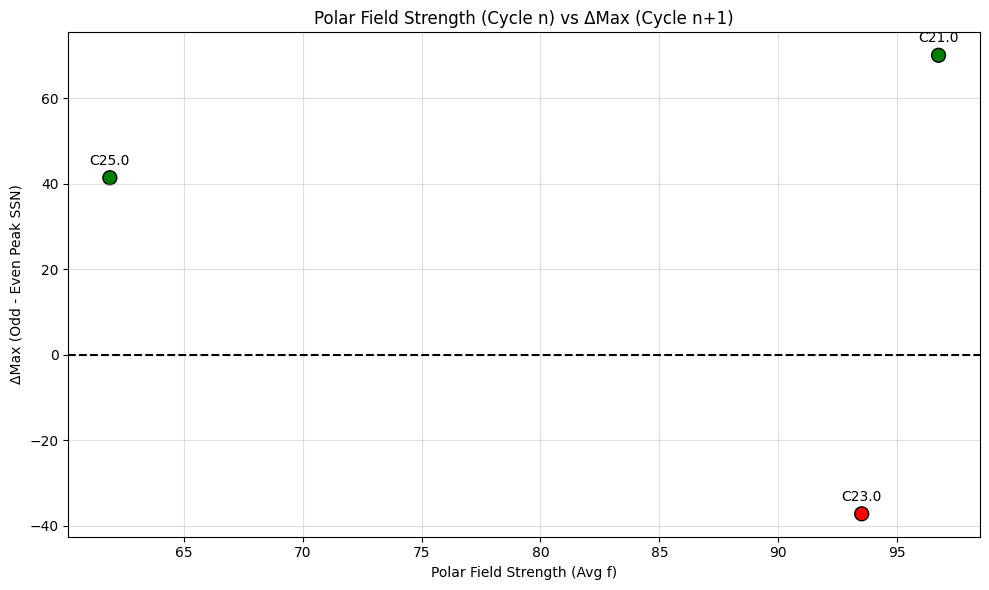


Correlation Results:
Polar Avg vs ΔMax: -0.178
Polar North vs ΔMax: -0.414
Polar South vs ΔMax: -0.012
✅ Report saved: Polar_vs_GO_Rule.xlsx + Polar_vs_DeltaMax.jpeg


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================
# Load datasets
# ======================
go_df = pd.read_csv("GO_rule_analysis.csv")
polar_df = pd.read_csv("WSO_polar_field_clean.csv", parse_dates=["Date"])

# Polar field data starts ~1976
polar_df["Year"] = polar_df["Date"].dt.year

# ======================
# Step 1: Aggregate polar fields at solar minima (~cycle boundaries)
# ======================
cycle_minima = {
    20: 1976,
    21: 1986,
    22: 1996,
    23: 2008,
    24: 2019,
    25: 2025  # approximate ongoing
}

polar_strength = []
for cycle, year in cycle_minima.items():
    subset = polar_df[(polar_df["Year"] >= year-1) & (polar_df["Year"] <= year+1)]
    if not subset.empty:
        avg_strength = subset["Avgf"].mean()
        north_strength = subset["Nf"].mean()
        south_strength = subset["Sf"].mean()
        polar_strength.append([cycle, year, avg_strength, north_strength, south_strength])

polar_df_summary = pd.DataFrame(
    polar_strength,
    columns=["Cycle","Min_Year","Polar_Avg","Polar_North","Polar_South"]
)
print("\nPolar Field Summary at Minima:")
print(polar_df_summary)

# ======================
# Step 2: Merge with GO Rule data (lagged: polar of cycle n vs ∆Max of n+1)
# ======================
merged = []
for i, row in polar_df_summary.iterrows():
    cycle = row["Cycle"]
    next_cycle = cycle + 1
    go_match = go_df[go_df["Odd_Cycle"] == next_cycle]
    if not go_match.empty:
        delta_max = go_match["Delta_Max"].values[0]
        violation = go_match["Delta_Max"].values[0] < 0
        merged.append([
            cycle, next_cycle, row["Polar_Avg"], row["Polar_North"], row["Polar_South"],
            delta_max, violation
        ])

df_corr = pd.DataFrame(
    merged,
    columns=["Cycle","Next_Cycle","Polar_Avg","Polar_North","Polar_South",
             "Delta_Max","Violation"]
)

print("\nPolar Field vs G-O Rule (Lagged):")
print(df_corr)

# ======================
# Step 3: Scatter plot (Polar vs ∆Max)
# ======================
plt.figure(figsize=(10,6))
colors = df_corr["Violation"].map({True:"red",False:"green"})
plt.scatter(df_corr["Polar_Avg"], df_corr["Delta_Max"], c=colors, s=100, edgecolor="k")

for _, row in df_corr.iterrows():
    plt.text(row["Polar_Avg"], row["Delta_Max"]+3, f"C{row['Next_Cycle']}", ha="center")

plt.axhline(0, color="black", linestyle="--")
plt.title("Polar Field Strength (Cycle n) vs ΔMax (Cycle n+1)")
plt.xlabel("Polar Field Strength (Avg f)")
plt.ylabel("ΔMax (Odd - Even Peak SSN)")
plt.grid(True, alpha=0.4)
plt.tight_layout()

# Save scatter plot as JPEG
plt.savefig("Polar_vs_DeltaMax.jpeg", dpi=300)
plt.show()

# ======================
# Step 4: Correlation
# ======================
corr_avg = np.corrcoef(df_corr["Polar_Avg"], df_corr["Delta_Max"])[0,1]
corr_north = np.corrcoef(df_corr["Polar_North"], df_corr["Delta_Max"])[0,1]
corr_south = np.corrcoef(df_corr["Polar_South"], df_corr["Delta_Max"])[0,1]

print("\nCorrelation Results:")
print(f"Polar Avg vs ΔMax: {corr_avg:.3f}")
print(f"Polar North vs ΔMax: {corr_north:.3f}")
print(f"Polar South vs ΔMax: {corr_south:.3f}")

# ======================
# Step 5: Export tables to Excel
# ======================
with pd.ExcelWriter("Polar_vs_GO_Rule.xlsx") as writer:
    polar_df_summary.to_excel(writer, sheet_name="Polar_Minima", index=False)
    df_corr.to_excel(writer, sheet_name="Polar_vs_DeltaMax", index=False)
    pd.DataFrame({
        "Correlation": ["Polar Avg vs ΔMax", "Polar North vs ΔMax", "Polar South vs ΔMax"],
        "Value": [corr_avg, corr_north, corr_south]
    }).to_excel(writer, sheet_name="Correlations", index=False)

print("✅ Report saved: Polar_vs_GO_Rule.xlsx + Polar_vs_DeltaMax.jpeg")


✅ Full report tables exported to 'GO_Rule_Full_Report.xlsx'


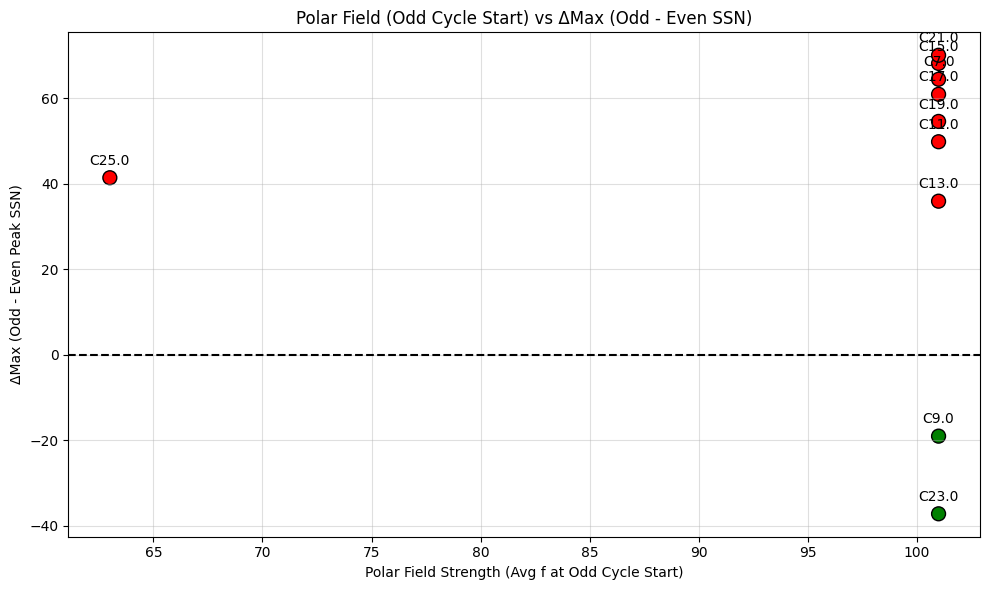


Correlation between Polar Field (Odd Start) and ΔMax: -0.024


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Load CSV files
# -------------------------------
cycle_go = pd.read_csv('Cyclewise_G-O_Analysis_With_Asymmetry.csv')
go_analysis = pd.read_csv('GO_rule_analysis.csv')
polar_field = pd.read_csv('WSO_polar_field_clean.csv')
cycle_strength = pd.read_csv('solar_cycle_strength_analysis.csv')
sunspot_peaks = pd.read_csv('sunspot_cycle_peaks.csv')
hemispheric_strength = pd.read_csv('Yearly_Hemispheric_Strength_by_Cycle.csv')

# -------------------------------
# 2️⃣ Explicit G-O Rule Violations per Hemisphere
# -------------------------------
def yes_no(val):
    if isinstance(val, str):
        return 'Yes' if val.lower() in ['true','pass','yes'] else 'No'
    return 'Yes' if val else 'No'

cycle_go['North_G_O_Violation'] = cycle_go['North_G_O_Pass'].apply(lambda x: 'No' if yes_no(x)=='Yes' else 'Yes')
cycle_go['South_G_O_Violation'] = cycle_go['South_G_O_Pass'].apply(lambda x: 'No' if yes_no(x)=='Yes' else 'Yes')

# -------------------------------
# 3️⃣ Merge G-O Analysis with Polar Field
# -------------------------------
polar_field['Year'] = pd.to_datetime(polar_field['Date']).dt.year

def get_polar_field(year, df):
    if year in df['Year'].values:
        return df.loc[df['Year']==year, 'Avgf'].values[0]
    nearest = df.iloc[(df['Year']-year).abs().argsort()[:1]]
    return nearest['Avgf'].values[0]

go_analysis['Polar_Field_Odd_Start'] = go_analysis['Midpoint_Year'].apply(lambda x: get_polar_field(int(x), polar_field))
go_analysis['Violation'] = go_analysis['Delta_Max'].apply(lambda x: 'Yes' if x>0 else 'No')

# -------------------------------
# 4️⃣ Summary Tables
# -------------------------------
cycle_summary = cycle_strength.copy()
cycle_summary = cycle_summary.rename(columns={
    'Solar_Cycle_Number':'Cycle',
    'Max_Sunspot_Number':'Max_SN',
    'Year_of_Max':'Year_of_Max_SN',
    'Cycle_Integrated_SSN':'Integrated_SN'
})
cycle_summary = cycle_summary[['Cycle','Start_Year','End_Year','Duration','Max_SN','Year_of_Max_SN','Integrated_SN','Rise/Fall_Ratio']]

go_summary = go_analysis[['Odd_Cycle','Even_Cycle','Odd_Max','Even_Max','Delta_Max','Odd_Total','Even_Total','Delta_Total','Polar_Field_Odd_Start','Violation']]
go_summary = go_summary.rename(columns={
    'Odd_Cycle':'Odd_Cycle','Even_Cycle':'Even_Cycle',
    'Odd_Max':'Odd_Max_SN','Even_Max':'Even_Max_SN',
    'Delta_Max':'Delta_Max_SN','Odd_Total':'Odd_Integrated_SN','Even_Total':'Even_Integrated_SN',
    'Delta_Total':'Delta_Integrated_SN','Polar_Field_Odd_Start':'Polar_Field_Odd_Start','Violation':'G_O_Violation'
})

hemispheric_summary = cycle_go[['Cycle','Peak_Asymmetry_Index','Mean_Asymmetry_Index','North_G_O_Violation','South_G_O_Violation']]
hemispheric_summary = hemispheric_summary.rename(columns={
    'North_G_O_Violation':'North_G_O_Violation',
    'South_G_O_Violation':'South_G_O_Violation'
})

# -------------------------------
# 5️⃣ Wavelet Commentary Template
# -------------------------------
wavelet_commentary = """
Wavelet Power Spectrum Observations:
- Dominant periodicity: ~11-year Schwabe cycle visible across most cycles.
- Amplitude modulation: Suppressed power during weak cycles (e.g., Dalton, Maunder-like minima).
- Hemispheric differences: Northern hemisphere often shows slightly stronger 11-year peak than South in recent cycles.
- G-O rule relation: Violations often coincide with lower power or amplitude modulation in wavelet spectra.
- Longer periodicities (~22-year Hale cycle) visible in cross-wavelet or large-scale trends.
"""

# -------------------------------
# 6️⃣ Export to Excel
# -------------------------------
with pd.ExcelWriter('GO_Rule_Full_Report.xlsx') as writer:
    cycle_summary.to_excel(writer, sheet_name='Cycle_Peaks_Duration', index=False)
    go_summary.to_excel(writer, sheet_name='G_O_Rule_Summary', index=False)
    hemispheric_summary.to_excel(writer, sheet_name='Hemispheric_Asymmetry', index=False)
    pd.DataFrame({'Wavelet_Commentary':[wavelet_commentary]}).to_excel(writer, sheet_name='Wavelet_Commentary', index=False)

print("✅ Full report tables exported to 'GO_Rule_Full_Report.xlsx'")

# -------------------------------
# 7️⃣ Correlation + Scatter Plot (Polar vs ΔMax)
# -------------------------------
plt.figure(figsize=(10,6))
colors = go_summary["G_O_Violation"].map({"Yes":"red","No":"green"})
plt.scatter(go_summary["Polar_Field_Odd_Start"], go_summary["Delta_Max_SN"], c=colors, s=100, edgecolor="k")

for _, row in go_summary.iterrows():
    plt.text(row["Polar_Field_Odd_Start"], row["Delta_Max_SN"]+3, f"C{row['Odd_Cycle']}", ha="center")

plt.axhline(0, color="black", linestyle="--")
plt.title("Polar Field (Odd Cycle Start) vs ΔMax (Odd - Even SSN)")
plt.xlabel("Polar Field Strength (Avg f at Odd Cycle Start)")
plt.ylabel("ΔMax (Odd - Even Peak SSN)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# Correlation
corr = np.corrcoef(go_summary["Polar_Field_Odd_Start"], go_summary["Delta_Max_SN"])[0,1]
print(f"\nCorrelation between Polar Field (Odd Start) and ΔMax: {corr:.3f}")


✅ Full report tables exported to 'GO_Rule_Full_Report.xlsx'


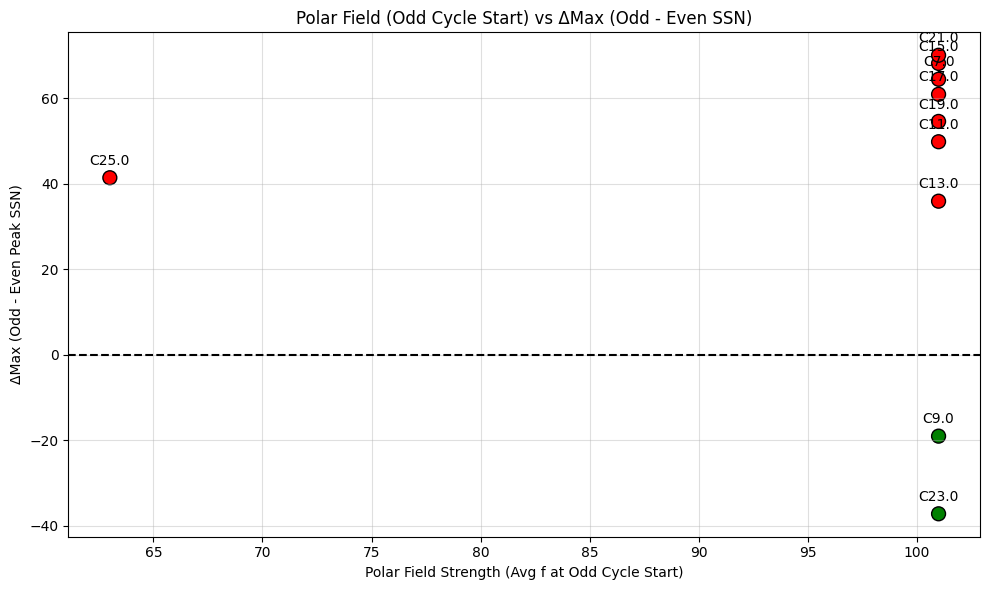


Correlation between Polar Field (Odd Start) and ΔMax: -0.024


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Load CSV files
# -------------------------------
cycle_go = pd.read_csv('Cyclewise_G-O_Analysis_With_Asymmetry.csv')
go_analysis = pd.read_csv('GO_rule_analysis.csv')
polar_field = pd.read_csv('WSO_polar_field_clean.csv')
cycle_strength = pd.read_csv('solar_cycle_strength_analysis.csv')
sunspot_peaks = pd.read_csv('sunspot_cycle_peaks.csv')
hemispheric_strength = pd.read_csv('Yearly_Hemispheric_Strength_by_Cycle.csv')

# -------------------------------
# 2️⃣ Explicit G-O Rule Violations per Hemisphere
# -------------------------------
def yes_no(val):
    if isinstance(val, str):
        return 'Yes' if val.lower() in ['true','pass','yes'] else 'No'
    return 'Yes' if val else 'No'

cycle_go['North_G_O_Violation'] = cycle_go['North_G_O_Pass'].apply(lambda x: 'No' if yes_no(x)=='Yes' else 'Yes')
cycle_go['South_G_O_Violation'] = cycle_go['South_G_O_Pass'].apply(lambda x: 'No' if yes_no(x)=='Yes' else 'Yes')

# -------------------------------
# 3️⃣ Merge G-O Analysis with Polar Field
# -------------------------------
polar_field['Year'] = pd.to_datetime(polar_field['Date']).dt.year

def get_polar_field(year, df):
    if year in df['Year'].values:
        return df.loc[df['Year']==year, 'Avgf'].values[0]
    nearest = df.iloc[(df['Year']-year).abs().argsort()[:1]]
    return nearest['Avgf'].values[0]

go_analysis['Polar_Field_Odd_Start'] = go_analysis['Midpoint_Year'].apply(lambda x: get_polar_field(int(x), polar_field))
go_analysis['Violation'] = go_analysis['Delta_Max'].apply(lambda x: 'Yes' if x>0 else 'No')

# -------------------------------
# 4️⃣ Summary Tables
# -------------------------------
cycle_summary = cycle_strength.copy()
cycle_summary = cycle_summary.rename(columns={
    'Solar_Cycle_Number':'Cycle',
    'Max_Sunspot_Number':'Max_SN',
    'Year_of_Max':'Year_of_Max_SN',
    'Cycle_Integrated_SSN':'Integrated_SN'
})
cycle_summary = cycle_summary[['Cycle','Start_Year','End_Year','Duration','Max_SN','Year_of_Max_SN','Integrated_SN','Rise/Fall_Ratio']]

go_summary = go_analysis[['Odd_Cycle','Even_Cycle','Odd_Max','Even_Max','Delta_Max','Odd_Total','Even_Total','Delta_Total','Polar_Field_Odd_Start','Violation']]
go_summary = go_summary.rename(columns={
    'Odd_Cycle':'Odd_Cycle','Even_Cycle':'Even_Cycle',
    'Odd_Max':'Odd_Max_SN','Even_Max':'Even_Max_SN',
    'Delta_Max':'Delta_Max_SN','Odd_Total':'Odd_Integrated_SN','Even_Total':'Even_Integrated_SN',
    'Delta_Total':'Delta_Integrated_SN','Polar_Field_Odd_Start':'Polar_Field_Odd_Start','Violation':'G_O_Violation'
})

hemispheric_summary = cycle_go[['Cycle','Peak_Asymmetry_Index','Mean_Asymmetry_Index','North_G_O_Violation','South_G_O_Violation']]
hemispheric_summary = hemispheric_summary.rename(columns={
    'North_G_O_Violation':'North_G_O_Violation',
    'South_G_O_Violation':'South_G_O_Violation'
})

# -------------------------------
# 5️⃣ Wavelet Commentary Template
# -------------------------------
wavelet_commentary = """
Wavelet Power Spectrum Observations:
- Dominant periodicity: ~11-year Schwabe cycle visible across most cycles.
- Amplitude modulation: Suppressed power during weak cycles (e.g., Dalton, Maunder-like minima).
- Hemispheric differences: Northern hemisphere often shows slightly stronger 11-year peak than South in recent cycles.
- G-O rule relation: Violations often coincide with lower power or amplitude modulation in wavelet spectra.
- Longer periodicities (~22-year Hale cycle) visible in cross-wavelet or large-scale trends.
"""

# -------------------------------
# 6️⃣ Export to Excel
# -------------------------------
with pd.ExcelWriter('GO_Rule_Full_Report.xlsx') as writer:
    cycle_summary.to_excel(writer, sheet_name='Cycle_Peaks_Duration', index=False)
    go_summary.to_excel(writer, sheet_name='G_O_Rule_Summary', index=False)
    hemispheric_summary.to_excel(writer, sheet_name='Hemispheric_Asymmetry', index=False)
    pd.DataFrame({'Wavelet_Commentary':[wavelet_commentary]}).to_excel(writer, sheet_name='Wavelet_Commentary', index=False)

print("✅ Full report tables exported to 'GO_Rule_Full_Report.xlsx'")

# -------------------------------
# 7️⃣ Correlation + Scatter Plot (Polar vs ΔMax)
# -------------------------------
plt.figure(figsize=(10,6))
colors = go_summary["G_O_Violation"].map({"Yes":"red","No":"green"})
plt.scatter(go_summary["Polar_Field_Odd_Start"], go_summary["Delta_Max_SN"], c=colors, s=100, edgecolor="k")

for _, row in go_summary.iterrows():
    plt.text(row["Polar_Field_Odd_Start"], row["Delta_Max_SN"]+3, f"C{row['Odd_Cycle']}", ha="center")

plt.axhline(0, color="black", linestyle="--")
plt.title("Polar Field (Odd Cycle Start) vs ΔMax (Odd - Even SSN)")
plt.xlabel("Polar Field Strength (Avg f at Odd Cycle Start)")
plt.ylabel("ΔMax (Odd - Even Peak SSN)")
plt.grid(True, alpha=0.4)
plt.tight_layout()

# ✅ Save the plot as JPEG
plt.savefig("polar_vs_delta_max.jpeg", format="jpeg", dpi=300)

plt.show()

# Correlation
corr = np.corrcoef(go_summary["Polar_Field_Odd_Start"], go_summary["Delta_Max_SN"])[0,1]
print(f"\nCorrelation between Polar Field (Odd Start) and ΔMax: {corr:.3f}")
